
# **Deep Learning for ECG Analysis - Residual CNNs & Interpretability**
## Access interpretability through preprocessing

#### In this notebook I will present an approach to make the results of a deep learning model interpretable in such a way that the classification decision becomes comprehensible for a physician. From a business perspective, such an algorithm is expected to have a significantly higher acceptance in terms of clinical implementation and is better aligned with EU regulatory requirements, particularly those set forth in the EU AI Act. We face a particular challenge here with regard to our database. We will discuss the problem and present 2 different approaches to address it. In this context, I will also present the deep-learning algorithm that performed best on the task. 

## **1. The Model:** 

### **Basic Data Prepataion:** 

In [1]:
# Loading Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import matplotlib.colors as mcolors

# Loading Data
mitbih_test_df = pd.read_csv("mitbih_test.csv")
mitbih_train_df = pd.read_csv("mitbih_train.csv")

# Renaming the columns
new_column_names = range(1, len(mitbih_train_df.columns) + 1)
mitbih_train_df.columns = new_column_names
new_column_names = range(1, len(mitbih_test_df.columns) + 1)
mitbih_test_df.columns = new_column_names

# Transforming the Target Variable to Integer
mitbih_train_df[188]=mitbih_train_df[188].astype(int)
mitbih_test_df[188]=mitbih_test_df[188].astype(int)

# Shuffle Rows
mitbih_train_df = mitbih_train_df.sample(frac=1, random_state=42).reset_index(drop=True)
mitbih_test_df = mitbih_test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
# Train Test Split (Original Data without further Preprocessing)
X_train_orig = mitbih_train_df.iloc[:, :-1]
y_train_orig = mitbih_train_df.iloc[:, -1]
X_test_orig = mitbih_test_df.iloc[:, :-1]
y_test_orig = mitbih_test_df.iloc[:, -1]

print("Number of Examples per Class Y_train_orig: ", dict(pd.Series(y_train_orig).value_counts()))
print("Number of Examples per Class Y_test_orig: ", dict(pd.Series(y_test_orig).value_counts()))

# One-hot encoding of target variables for multi-class classification
y_train_orig = to_categorical(y_train_orig, num_classes=5)
y_test_orig = to_categorical(y_test_orig, num_classes=5)

# Rounding of values on 3 digits
#X_train = np.round(X_train_orig, decimals=4) 
#X_test = np.round(X_test_orig, decimals=4)   

# Conversion of DataFrames into NumPy arrays and addition of a feature dimension
X_train_orig = np.expand_dims(X_train_orig.values, axis=-1)
X_test_orig = np.expand_dims(X_test_orig.values, axis=-1)

# Verification of correct Format
print("Shape of X_train_orig, y_train_orig: ", X_train_orig.shape, y_train_orig.shape) 
print("Shape of X_test_orig, y_test_orig: ", X_test_orig.shape, y_test_orig.shape) 

Number of Examples per Class Y_train_orig:  {0: 72470, 4: 6431, 2: 5788, 1: 2223, 3: 641}
Number of Examples per Class Y_test_orig:  {0: 18117, 4: 1608, 2: 1448, 1: 556, 3: 162}
Shape of X_train_orig, y_train_orig:  (87553, 187, 1) (87553, 5)
Shape of X_test_orig, y_test_orig:  (21891, 187, 1) (21891, 5)


### **Model Architecture:** 
**This model is a 1D Convolutional Neural Network (1D-CNN) architecture designed for multi-class classification with residual 
connections to improve feature learning especially for sequential Data.** 

**Key Components of the Model:**

1. Input Layer:
- The input shape is (187, 1), representing a time-series signal with 187 timesteps and a single feature. This korresponds to the EKG-Data.

2. Convolutional and Pooling Layers:
- The first layer is a Conv1D layer with 64 filters, kernel size of 3, and ReLU activation.
- A MaxPooling1D layer with a pool size of 2 is applied to downsample the input

3. Residual Blocks:
- The model includes three residual blocks, each consisting of:
    - Two Conv1D layers with the same filter size and kernel size of 3.
    - BatchNormalization layers after each convolution to stabilize and speed up training.
    - ReLU activation for non-linearity.
    - A shortcut connection adds the input to the block's output to form a residual connection.
    - Filter sizes for the residual blocks:
        - Block 1: 64 filters
        - Block 2: 128 filters
        - Block 3: 256 filters

4. Flatten Layer:
- The output of the last residual block is flattened into a single vector with 23,808 elements to connect it to fully connected layers.

5. Fully Connected Dense Layers:
- The dense layers progressively reduce the feature dimensions:
    - First dense layer: 128 neurons with ReLU activation and a dropout of 40% to prevent overfitting.
    - Second dense layer: 64 neurons with ReLU activation and a dropout of 30% to prevent overfitting.

6. Output Layer:
- A dense layer with 5 neurons and a softmax activation function for multi-class classification. The model outputs probabilities for each of the 5 classes.

**Total Parameters:**
- The model has 3,449,469 trainable parameters, primarily concentrated in the dense layers and residual blocks.

**Optimizer and Loss Function:**
- The model uses the Adam optimizer with a learning rate of 0.0001 for adaptive gradient descent.
- The loss function is categorical_crossentropy, suitable for multi-class classification tasks.


In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import numpy as np

# Residual Block Definition
def residual_block(x, filters, kernel_size=3):
    # Shortcut connection
    shortcut = x

    # Adjust shortcut dimensions if necessary
    if x.shape[-1] != filters:
        shortcut = Conv1D(filters=filters, kernel_size=1, padding='same')(shortcut)
    
    # First Conv1D layer
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Conv1D layer
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Add the shortcut to the output
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Model input
inputs = Input(shape=(187, 1), name="Input")  # Shape adjusted according to preprocessing

# 1D-CNN layer with the best hyperparameters
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

# Residual block 1
x = residual_block(x, filters=64, kernel_size = 3)

# Residual block 2
x = residual_block(x, filters=128, kernel_size = 5)

# Residual block 3
x = residual_block(x, filters=256, kernel_size = 7)

# Flatten layer
x = Flatten()(x)

# Dense layers with the best dropout values
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)  # Best dropout for layer 1

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)  # Best dropout for layer 2

# Output layer for multi-class classification
output_layer = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=output_layer)

# Compile the model with the best learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Model Summary:")
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
training_history = model.fit(
    X_train_orig,
    y_train_orig,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
evaluation = model.evaluate(X_test_orig, y_test_orig)
print(f"Test loss: {evaluation[0]}, Test accuracy: {evaluation[1]}")

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 187, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 187, 64)   │        256 │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 93, 64)    │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 64)    │        256 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 93, 64)    │     12,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 64)    │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 93, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 93, 64)    │     12,352 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 64)    │        256 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 93, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 93, 64)    │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 93, 128)   │     41,088 │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 128)   │        512 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 93, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 93, 128)   │     82,048 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 128)   │        512 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 93, 128)   │      8,320 │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 93, 128)   │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 93, 128)   │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                 

 Total params: 3,938,053 (15.02 MB)

 Trainable params: 3,936,133 (15.02 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 110s 49ms/step - accuracy: 0.9089 - loss: 0.3444 - val_accuracy: 0.9753 - val_loss: 0.0946 - learning_rate: 1.0000e-04
Epoch 2/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 109s 50ms/step - accuracy: 0.9681 - loss: 0.1203 - val_accuracy: 0.9793 - val_loss: 0.0738 - learning_rate: 1.0000e-04
Epoch 3/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 110s 50ms/step - accuracy: 0.9752 - loss: 0.0903 - val_accuracy: 0.9812 - val_loss: 0.0751 - learning_rate: 1.0000e-04
Epoch 4/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 109s 50ms/step - accuracy: 0.9803 - loss: 0.0714 - val_accuracy: 0.9805 - val_loss: 0.0663 - learning_rate: 1.0000e-04
Epoch 5/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 110s 50ms/step - accuracy: 0.9827 - loss: 0.0609 - val_accuracy: 0.9824 - val_loss: 0.0658 - learning_rate: 1.0000e-04
Epoch 6/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 121s 55ms/step - accuracy: 0.9860 - loss: 0.0489 - val_accuracy: 0.9852 - val_loss: 0.0530 - learning_rate: 1.0000e-04
Epoch 7/50
2189/2189 ━━━━━━━━━━━━━

### **Results on original Data:**

685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     18117
           1       0.92      0.83      0.87       556
           2       0.97      0.96      0.97      1448
           3       0.91      0.79      0.85       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21891
   macro avg       0.96      0.91      0.94     21891
weighted avg       0.99      0.99      0.99     21891

685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step

 Weighted F1-Score: 0.9883902560247574


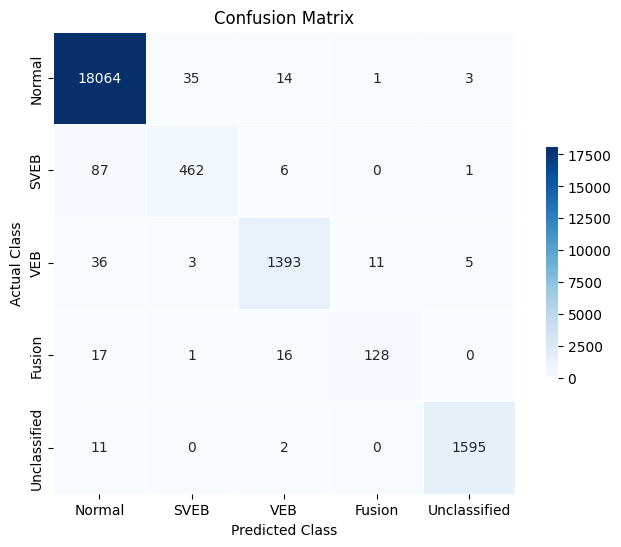

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

y_pred_orig = model.predict(X_test_orig)
y_pred_classes_orig = np.argmax(y_pred_orig, axis=1)
y_true_classes_orig = np.argmax(y_test_orig, axis=1)
report = classification_report(y_true_classes_orig, y_pred_classes_orig)
print("Classification report: \n", report)

# weighted F1-Score
y_pred_orig = model.predict(X_test_orig)
y_pred_classes_orig = np.argmax(y_pred_orig, axis=1)
y_true_classes_orig = np.argmax(y_test_orig, axis=1)
weighted_f1 = f1_score(
    y_true_classes_orig,
    y_pred_classes_orig,
    average="weighted"
)
print("\n Weighted F1-Score:", weighted_f1)

cm = confusion_matrix(y_true_classes_orig, y_pred_classes_orig)
class_names = ['Normal', 'SVEB', 'VEB', 'Fusion', 'Unclassified']
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


### **Additional performance metrics on original Data:**

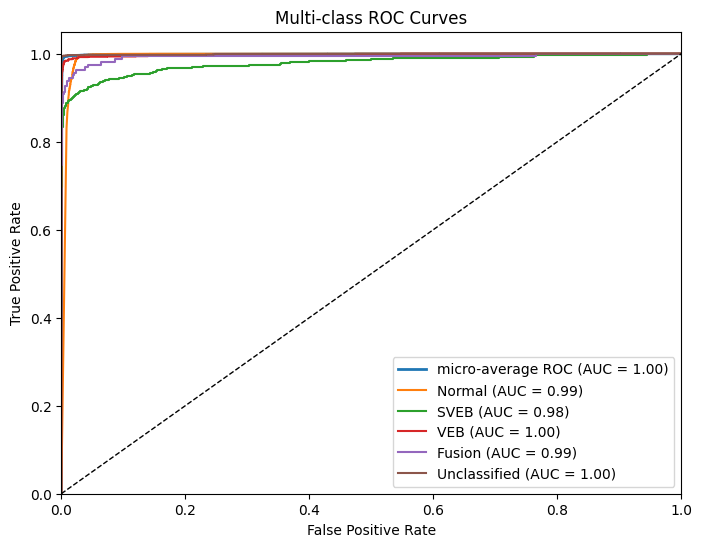

In [16]:
#Plot multiclass ROC curves and compute AUC for each class
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Number of target classes
n_classes = y_test_orig.shape[1]

# True labels are already one-hot encoded
y_true_bin = y_test_orig

# Predicted probabilities for each class
y_score = y_pred_orig

# Prepare containers for false positive rates, true positive rates, and AUCs
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_bin.ravel(),
    y_score.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC (AUC = {roc_auc['micro']:.2f})",
    linewidth=2
)

# Plot per-class ROC curves
for i, class_name in enumerate(class_names):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"{class_name} (AUC = {roc_auc[i]:.2f})"
    )

# Plot the chance diagonal
plt.plot([0, 1], [0, 1], "k--", linewidth=1)

# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curves")
plt.legend(loc="lower right")
plt.show()


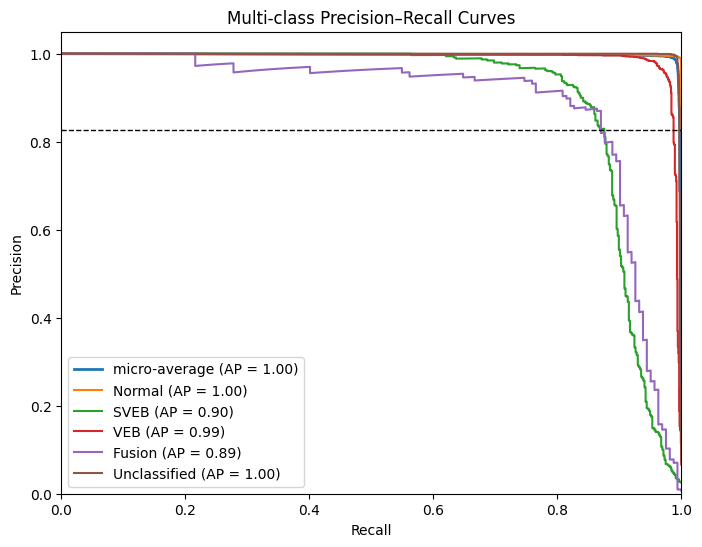

In [17]:
# Plot multiclass Precision–Recall curves and compute Average Precision for each class
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Number of classes
n_classes = y_test_orig.shape[1]

# True labels (one-hot) and predicted probabilities
y_true_bin = y_test_orig
y_score = y_pred_orig

# Containers for Precision–Recall data and average precision scores
precision = {}
recall = {}
avg_precision = {}

# Compute Precision–Recall curve and Average Precision for each class
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        y_true_bin[:, i],
        y_score[:, i]
    )
    avg_precision[i] = average_precision_score(
        y_true_bin[:, i],
        y_score[:, i]
    )

# Compute micro-average Precision–Recall curve and Average Precision
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_true_bin.ravel(),
    y_score.ravel()
)
avg_precision["micro"] = average_precision_score(
    y_true_bin,
    y_score,
    average="micro"
)

# Plot all Precision–Recall curves
plt.figure(figsize=(8, 6))

# Plot micro-average
plt.plot(
    recall["micro"],
    precision["micro"],
    label=f"micro-average (AP = {avg_precision['micro']:.2f})",
    linewidth=2
)

# Plot per-class
for i, class_name in enumerate(class_names):
    plt.plot(
        recall[i],
        precision[i],
        label=f"{class_name} (AP = {avg_precision[i]:.2f})"
    )

# Plot the no-skill line (baseline)
plt.plot([0, 1], [sum(y_true_bin[:, i]) / y_true_bin.shape[0] for i in [0,0]], "k--", linewidth=1)
# Note: for a multiclass problem, you may omit the no-skill line or compute per-class baselines individually.

# Configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision–Recall Curves")
plt.legend(loc="lower left")
plt.show()


#### The results of this Model on the original Data are quite satisfying with an overall accuracy of 99%. We will see how it changes depending on the level of Preprocessing. Wichtig - Ändern!!!

## **2. The Problem:**

### **Normal EKG-Signal:**
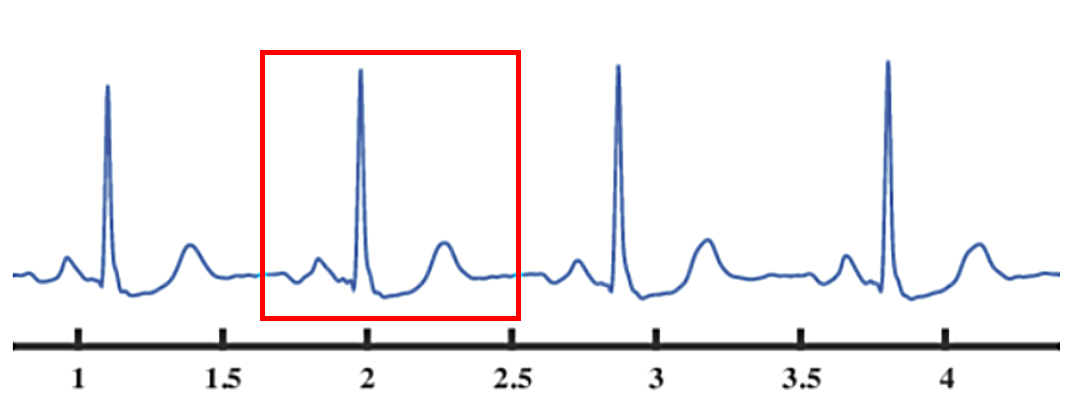

#### The graph shows a regular ECG signal. 
#### The signal begins with a P wave, followed by a QRS complex and finally the T wave. It is important to note that the shape of the T wave is determined by the QRS complex as it is sequential data and the T wave reflects the regression of excitation of the heart. 

### **Exemplary EKG-Signal from the MIT-BIH-Database:**

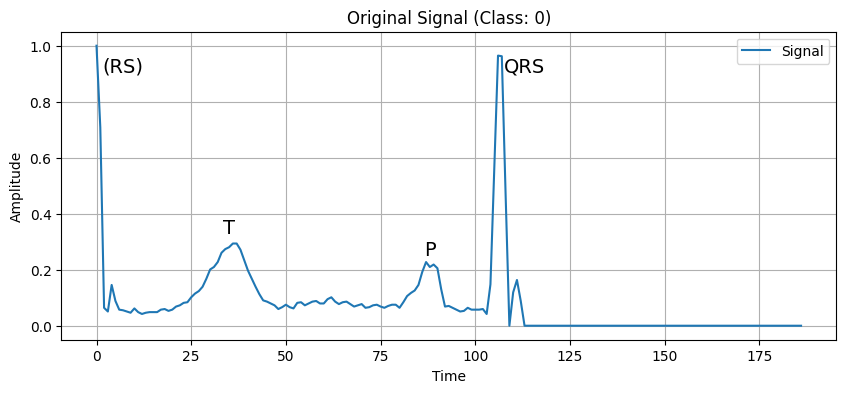

In [18]:
# Visualization of an individual signal
idx_example = 1 

original_signal = mitbih_train_df.iloc[idx_example, :-1].values
class_label = mitbih_train_df.iloc[idx_example, -1]

plt.figure(figsize=(10, 4))
plt.plot(original_signal, label="Signal")
plt.title(f'Original Signal (Class: {class_label})')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)

plt.text(88, original_signal[30] + 0.05, "P", fontsize=14, color="black", ha="center")
plt.text(113, original_signal[100] + 0.85, "QRS", fontsize=14, color="black", ha="center")
plt.text(35, original_signal[35] + 0.05, "T", fontsize=14, color="black", ha="center")
plt.text(7, original_signal[100] + 0.85, "(RS)", fontsize=14, color="black", ha="center")

plt.legend()
plt.show()

#### We can see that the Signal (here as an example a normal heartbeat (Class:0)) deviates from the regular ECG signal in the following way:
#### - In the column with index 0, the signal starts as an annotation signal, triggered by the maximum of a QRS complex. The signal therefore begins with an incomplete QRS complex (actually only RS-Complex).
#### - This is followed by the T wave, which represents the regression of the excitation of the incompletely imaged QRS complex.
#### - If present, the P-wave then occurs.
#### - This is followed by the actual QRS complex which needs to be analyzed. 
#### <u> This means: To determine the heart rhythm (class 0-4) a T-wave is used which is not related to the QRS complex which is primarily analyzed. <u>


### **Averaged EKG-Signal by Class (MIT-BIH-Train Database):**

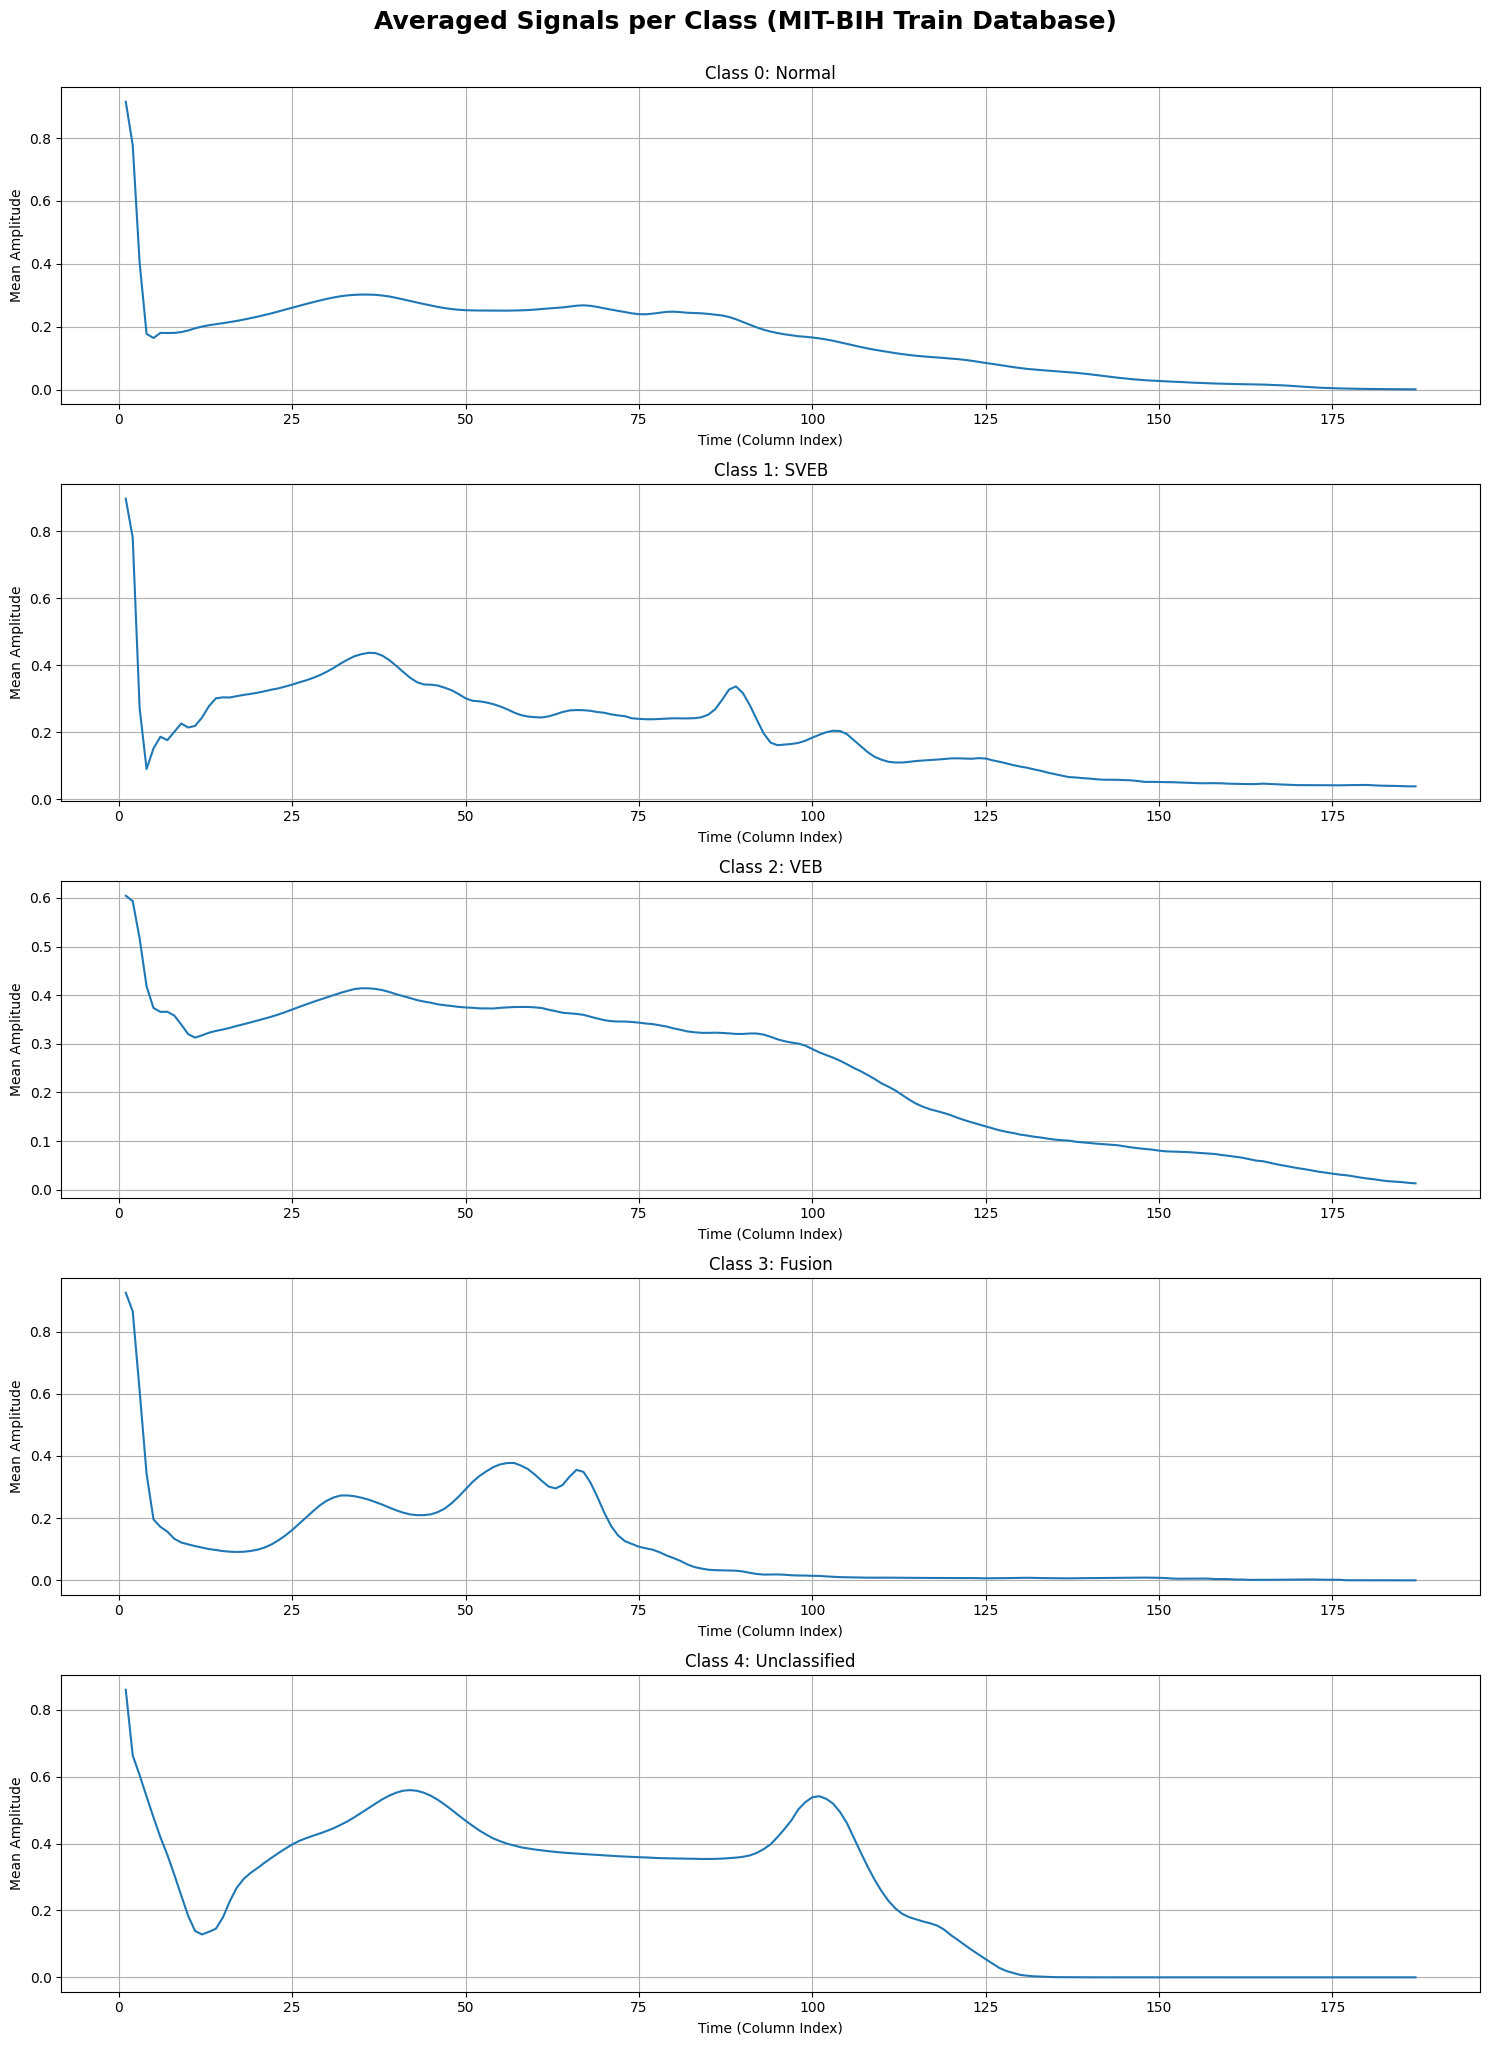

In [19]:
import matplotlib.pyplot as plt

# Define class labels
class_names = ['Normal', 'SVEB', 'VEB', 'Fusion', 'Unclassified']

# Function to calculate and visualize the average signals for each class
def plot_average_signals(df, title, class_names):
    signal_columns = df.columns[:-1]  # All columns except the last one (signal data)
    classes = df[df.columns[-1]].unique()  # Extract unique class labels from the last column
    classes.sort()  # Sort classes for consistent visualization

    # Create subplots for each class
    fig, axs = plt.subplots(len(classes), 1, figsize=(15, 20))

    for i, cls in enumerate(classes):
        # Filter data for the current class
        class_data = df[df[df.columns[-1]] == cls]
        # Calculate the mean signal for the current class
        mean_signal = class_data[signal_columns].mean(axis=0)

        # Plot the mean signal
        axs[i].plot(signal_columns, mean_signal)
        axs[i].set_title(f'Class {int(cls)}: {class_names[int(cls)]}')
        axs[i].set_ylabel('Mean Amplitude')
        axs[i].set_xlabel('Time (Column Index)')
        axs[i].grid(True)

    # Adjust layout and add a main title
    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=18,fontweight="bold")
    plt.show()

# Visualization for training data with class labels
plot_average_signals(mitbih_train_df, 'Averaged Signals per Class (MIT-BIH Train Database)', class_names)


#### The graph shows the averaged ECG signals for the MIT-BIH-Train database divided into the different diagnostic classes. It can be seen that even if there are clear differences between the averaged signals for the various classes, they bear no resemblance to a “normal” ECG signal. 
#### The reason for this phenomenon is as follows: The R-R intervals vary greatly depending on the respective heart rate. Since rhythm (class 0-4) and heart rate are largely independent of each other, the second QRS complex of a signal occurs at completely different column indices. For the P-QRS interval, the dependence on the heart rate is much less pronounced. I use this phenomenon in relation to the following manipulation of the data.

## **3. Preprocessor No. 1 - High Data Alteration (P-QRS-T)**:

In [20]:
def preprocess_ecg_signals_1(df, peak_col_index=32):
    """
    - Preprocess ECG signals to align the maximum value (R-wave) to the same column.
    - All values from the original signal remain unchanged and are only shifted.
    - In the case of a left shift, the truncated values are inserted at the point where zero-padding begins,
    but only if there are at least 10 consecutive zeros from that point onward.
    - If the first value of the truncated values differs by more than 0.05 from the last value before padding,
    the truncated values are adjusted by the difference.
    - No values are altered or duplicated.
    - Additionally, the number of left shifts, right shifts, and no shifts are counted.

    Parameters:
    - df: DataFrame containing ECG signals, with labels in the last column.
    - peak_col_index: Index of the column where the maximum value (R-wave) should be aligned (after column removal).

    Returns:
    - df_preprocessed: Preprocessed DataFrame.
    - shift_counts: Dictionary containing the number of left, right, and no shifts.
    """
    # 1. Remove the first 22 columns
    df = df.drop(df.columns[0:22], axis=1).reset_index(drop=True)

    # Signal columns (excluding the label column)
    signal_columns = df.columns[:-1]

    # Total number of signal columns
    num_cols = len(signal_columns)

    # Initialize shift counters
    left_shift_count = 0
    right_shift_count = 0
    no_shift_count = 0

    # Process each row
    for idx in df.index:
        signal = df.loc[idx, signal_columns].values

        # 2. Identify the maximum value (R-wave)
        max_index = np.argmax(signal)

        # 3. Calculate the shift
        shift = peak_col_index - max_index  # Positive: right shift, Negative: left shift

        if shift > 0:
            # Right shift
            right_shift_count += 1

            end_part = signal[-shift:]       # Last 'shift' elements
            main_part = signal[:-shift]      # Remaining signal

            # Create the new signal
            new_signal = np.concatenate((end_part, main_part))

        elif shift < 0:
            # Left shift
            left_shift_count += 1

            shift_abs = -shift
            main_part = signal[shift_abs:]   # Signal starting from 'shift_abs'
            start_part = signal[:shift_abs]  # First 'shift_abs' elements

            # Find the starting position of padding (minimum 10 consecutive zeros)
            def find_padding_start(sig, min_zero_length=10):
                zero_runs = (sig == 0).astype(int)
                convolved = np.convolve(zero_runs, np.ones(min_zero_length, dtype=int), mode='valid')
                padding_starts = np.where(convolved == min_zero_length)[0]
                if len(padding_starts) > 0:
                    return padding_starts[0]
                else:
                    return None

            zero_index = find_padding_start(main_part, min_zero_length=10)
            if zero_index is not None:
                # Insert the truncated values at the padding location
                before_padding = main_part[:zero_index]
                after_padding = main_part[zero_index:]

                # Check the difference between signal values
                if len(before_padding) > 0:
                    last_value_before_padding = before_padding[-1]
                    first_value_of_start_part = start_part[0]

                    difference = first_value_of_start_part - last_value_before_padding

                    if abs(difference) > 0.05:
                        # Adjust the truncated values
                        start_part = start_part - difference

                # Create the new signal
                new_signal = np.concatenate((before_padding, start_part, after_padding))
            else:
                # No padding found, append truncated values at the end
                new_signal = np.concatenate((main_part, start_part))
        else:
            # No shift required
            no_shift_count += 1
            new_signal = signal

        # Ensure the signal has the original length
        if len(new_signal) < num_cols:
            # Pad with zeros at the end
            new_signal = np.concatenate((new_signal, np.zeros(num_cols - len(new_signal))))
        elif len(new_signal) > num_cols:
            # Truncate the signal to the original length
            new_signal = new_signal[:num_cols]

        # Update the DataFrame
        df.loc[idx, signal_columns] = new_signal

    # Create a dictionary with shift counts
    shift_counts = {
        'left_shifts': left_shift_count,
        'right_shifts': right_shift_count,
        'no_shifts': no_shift_count
    }

    return df.reset_index(drop=True), shift_counts


In [21]:
# Use on Train and Test Data: 
mitbih_train_df_preprocessed, train_shift_counts = preprocess_ecg_signals_1(mitbih_train_df.copy(), peak_col_index=32)
mitbih_test_df_preprocessed, test_shift_counts = preprocess_ecg_signals_1(mitbih_test_df.copy(), peak_col_index=32)


### **What does `preprocess_ecg_signals_1` do?**

1. **Purpose**: Preprocess ECG signals to align the maximum value (R-wave) to a specified column while preserving all original values.

2. **Key Features**:
   - **Column removal**: Removes the first 22 columns to eliminate duplication and spikes for better alignment.
   - **R-peak alignment**: Aligns the R-wave to a specified column (`peak_col_index`).

3. **Steps**:
   - **R-peak detection**: Identifies the maximum value (R-wave) in the signal after removing the first 22 columns.
   - **Shift calculation**:
     - Positive shifts: Right shift of the signal.
     - Negative shifts: Left shift of the signal.
   - **Signal shifting**:
     - **Right Shift**: Moves the end part of the signal to the front, aligning the R-wave with the specified column.
     - **Left Shift**:
       - Locates where padding with at least 10 consecutive zeros begins.
       - Reinserts the truncated signal values at the padding position if possible.
       - Adjusts truncated signal values if the difference between the first truncated value and the last value before padding exceeds 0.05.
       - Moves the start of the signal to the padding position, preserving all original values.
   - **Signal length consistency**:
     - Ensures the processed signal retains the original length by:
       - Padding with zeros if the signal is shorter.
       - Truncating the signal if it becomes longer.

4. **Tracking shifts**:
   - Counts the number of left shifts, right shifts, and no shifts performed for reporting.

5. **Output**:
   - **Preprocessed DataFrame**: Contains the shifted ECG signals.
   - **Shift counts**: A dictionary with counts of left, right, and no shifts performed.



### **Comparison of Original and Preprocessed Signal:**

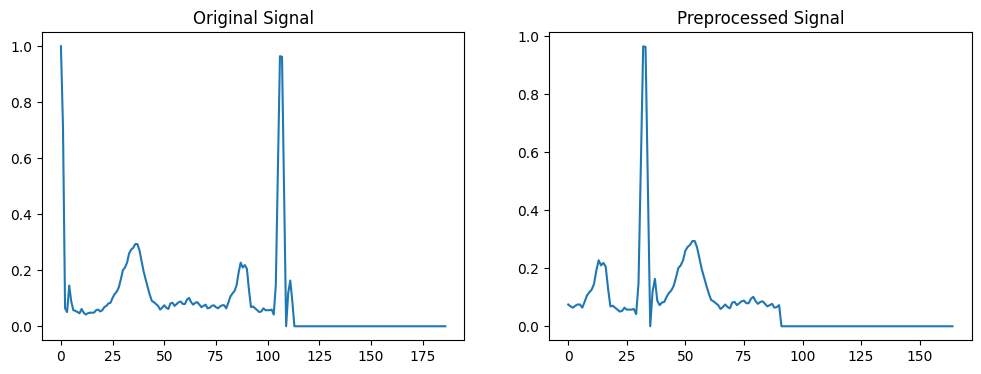

In [22]:
idx_example = 1  # Exemplary Index

original_signal = mitbih_train_df.drop(mitbih_train_df.columns[0:0], axis=1).iloc[idx_example, :-1].values
processed_signal = mitbih_train_df_preprocessed.iloc[idx_example, :-1].values

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(original_signal)
plt.title('Original Signal')

plt.subplot(1, 2, 2)
plt.plot(processed_signal)
plt.title('Preprocessed Signal')
plt.show()

In [12]:
print(train_shift_counts)
print(test_shift_counts)

{'left_shifts': 80509, 'right_shifts': 6792, 'no_shifts': 252}
{'left_shifts': 20120, 'right_shifts': 1702, 'no_shifts': 69}


### **Results of Averaged EKG-Signal by Class after `preprocess_ecg_signals_1`:**

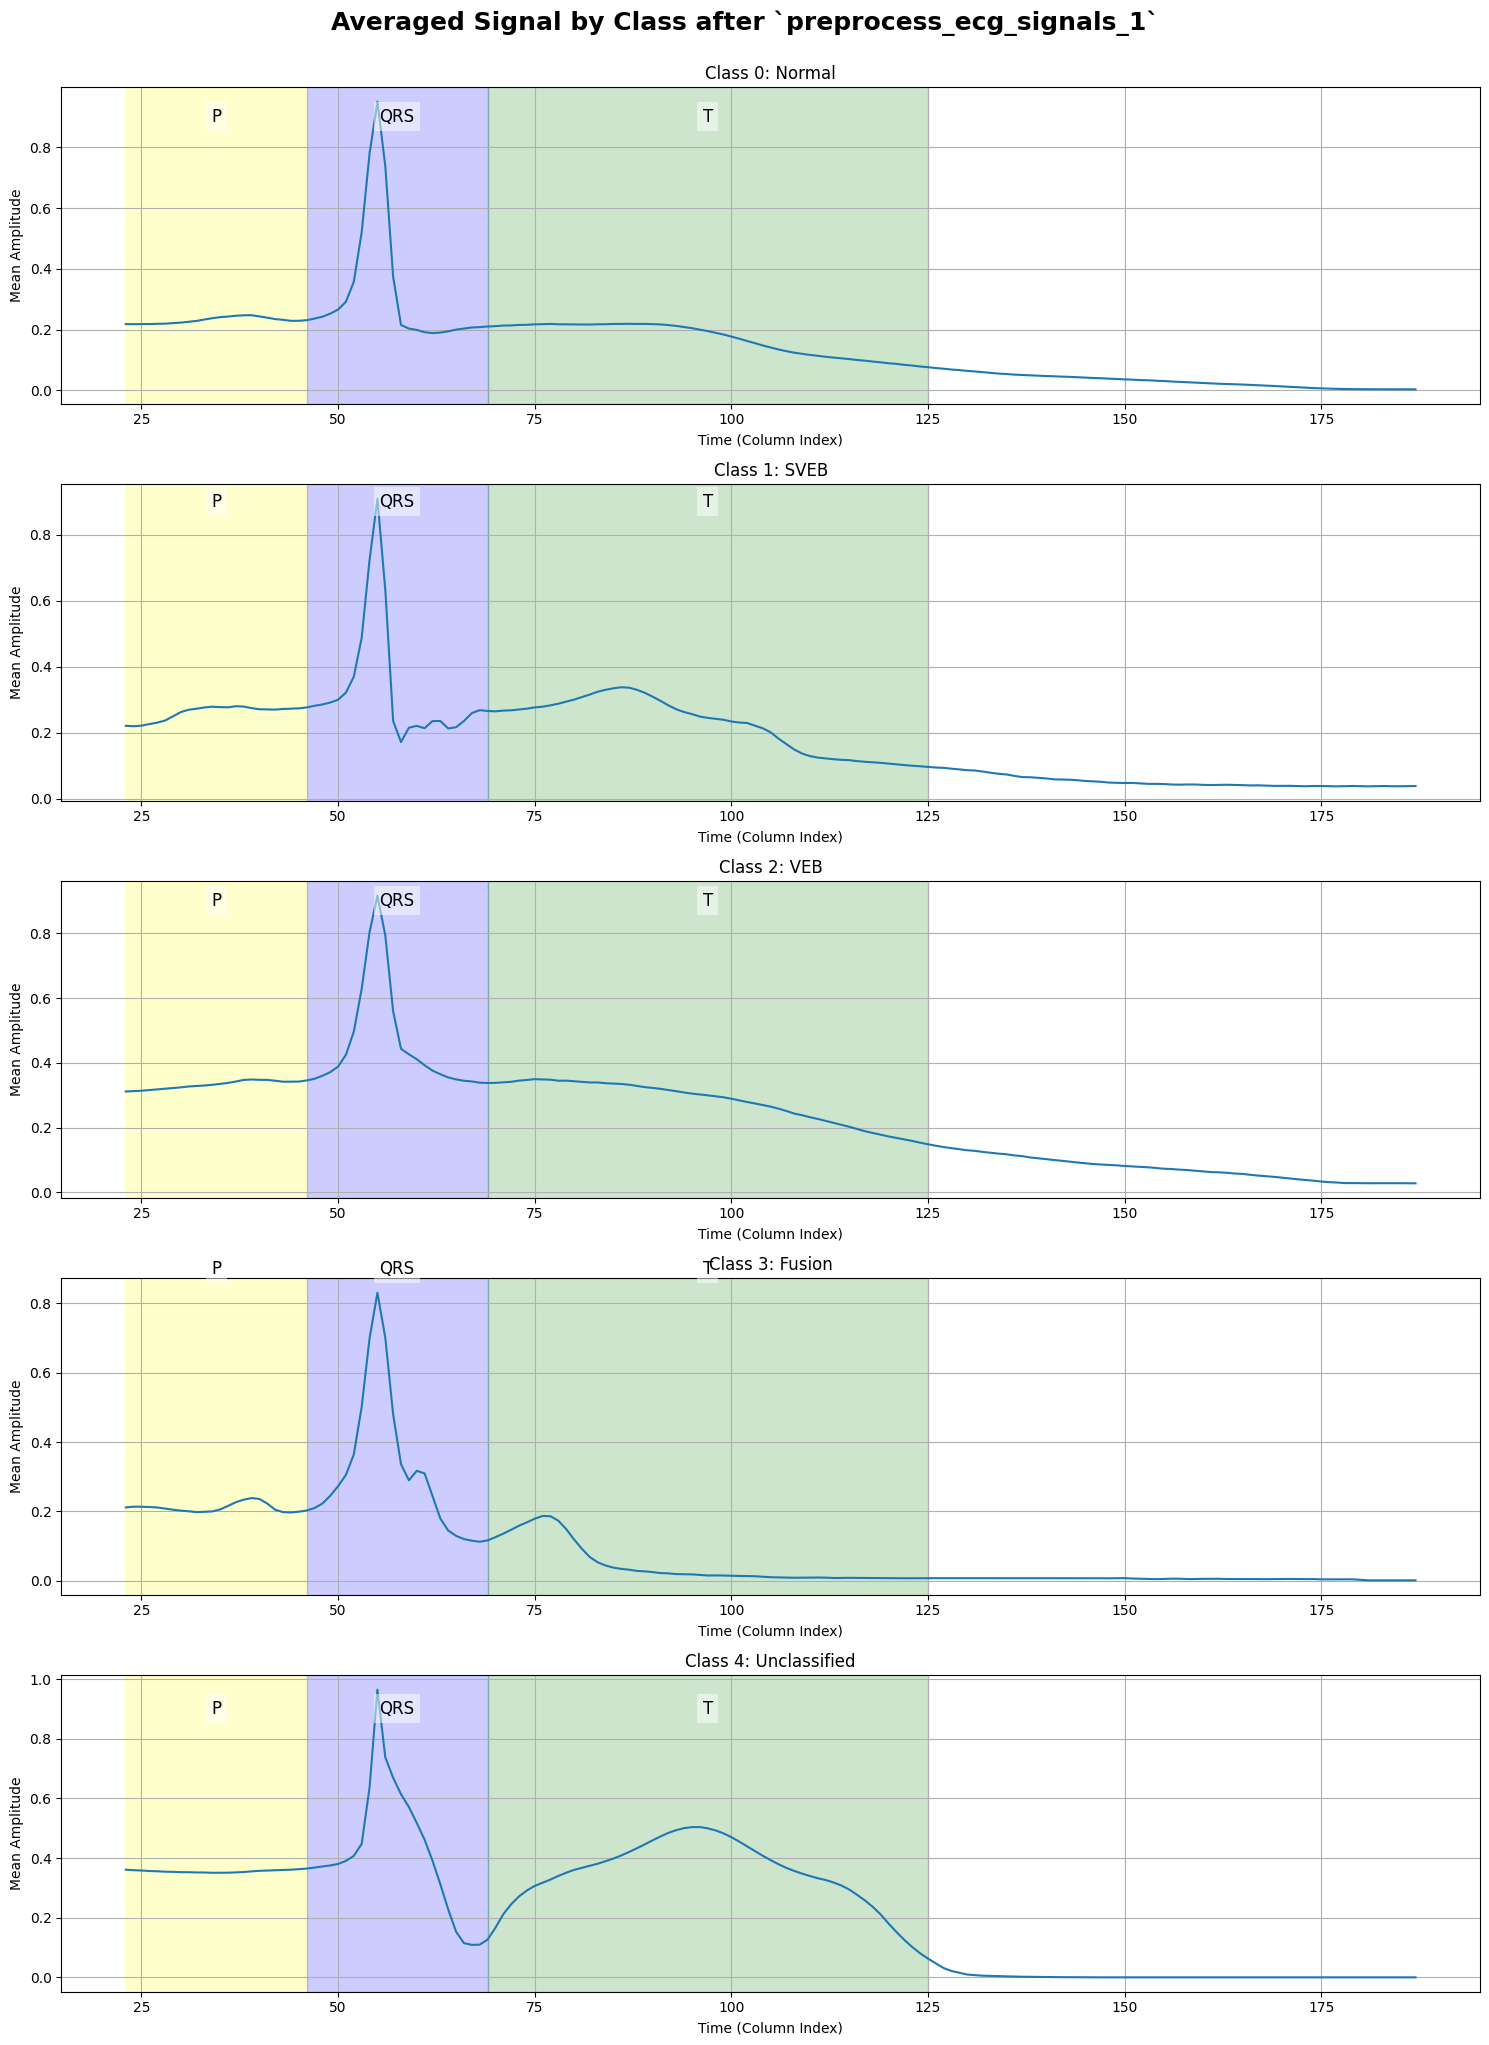

In [23]:

# Visualization of Mean-EKG Data (After Advanced Preprocessing)

class_names = ['Normal', 'SVEB', 'VEB', 'Fusion', 'Unclassified']

# Function to calculate and visualize the average signals for each class
def plot_average_signals_with_background(df, title, class_names):
    signal_columns = df.columns[:-1]  # All columns except the last one (signal data)
    classes = df[df.columns[-1]].unique()  # Extract unique class labels from the last column
    classes.sort()  # Sort classes for consistent visualization

    # Define color-coded regions and their labels
    regions = [
        {"range": (23, 46), "color": "yellow", "label": "P"},
        {"range": (46, 69), "color": "blue", "label": "QRS"},
        {"range": (69, 125), "color": "green", "label": "T"}
    ]

    # Create subplots for each class
    fig, axs = plt.subplots(len(classes), 1, figsize=(15, 20))

    for i, cls in enumerate(classes):
        # Filter data for the current class
        class_data = df[df[df.columns[-1]] == cls]
        # Calculate the mean signal for the current class
        mean_signal = class_data[signal_columns].mean(axis=0)

        # Plot the mean signal
        axs[i].plot(signal_columns, mean_signal, label='Mean Signal')
        axs[i].set_title(f'Class {int(cls)}: {class_names[int(cls)]}')
        axs[i].set_ylabel('Mean Amplitude')
        axs[i].set_xlabel('Time (Column Index)')
        axs[i].grid(True)

        # Add colored regions with text
        for region in regions:
            start, end = region["range"]
            color = region["color"]
            label = region["label"]
            axs[i].axvspan(start, end, color=color, alpha=0.2)
            text_x = (start + end) / 2
            axs[i].text(
                text_x, 0.9, label, fontsize=12, color="black",
                ha="center", va="center", bbox=dict(facecolor="white", alpha=0.5, edgecolor="none")
            )

    # Adjust layout and add a main title
    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=18, fontweight="bold")
    plt.show()

# Visualization for training data with class labels
plot_average_signals_with_background(mitbih_train_df_preprocessed, 'Averaged Signal by Class after `preprocess_ecg_signals_1`', class_names)


### **Advantages and Disadvantages of `preprocess_ekg_signals_1`:**
- Advantages: 
   - The resulting averaged signal is highly consistent with an individual ECG signal. 
   - The assignment is marked in color in the illustration. 
   
- Disadvantages: 
   - To display only one ECG cycle, 22 columns are deleted. This reduces the information content. 
   - Over 90% of all signals are shifted to the left. The T wave is therefore added to the QRS complex to which it does not actually belong. 

### **Modeling with `preprocess_ekg_signal_1`:**

In [24]:
# Train Test Split (Preprocessed Data)
X_train = mitbih_train_df_preprocessed.iloc[:, :-1]
y_train = mitbih_train_df_preprocessed.iloc[:, -1]
X_test = mitbih_test_df_preprocessed.iloc[:, :-1]
y_test = mitbih_test_df_preprocessed.iloc[:, -1]


y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

X_train = np.expand_dims(X_train.values, axis=-1)
X_test = np.expand_dims(X_test.values, axis=-1)

print("Shape of X_train, y_train: ", X_train.shape, y_train.shape)
print("Shape of X_test, y_test: ", X_test.shape, y_test.shape)

Shape of X_train, y_train:  (87553, 165, 1) (87553, 5)
Shape of X_test, y_test:  (21891, 165, 1) (21891, 5)


In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Residual Block Definition
def residual_block(x, filters, kernel_size=3):
    # Shortcut connection
    shortcut = x

    # Adjust shortcut dimensions if necessary
    if x.shape[-1] != filters:
        shortcut = Conv1D(filters=filters, kernel_size=1, padding='same')(shortcut)
    
    # First Conv1D layer
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Conv1D layer
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Add the shortcut to the output
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Model input
inputs = Input(shape=(165, 1), name="Input")  # Shape adjusted according to preprocessing

# 1D-CNN layer with the best hyperparameters
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

# Residual block 1
x = residual_block(x, filters=64)

# Residual block 2
x = residual_block(x, filters=128)

# Residual block 3
x = residual_block(x, filters=256)

# Flatten layer
x = Flatten()(x)

# Dense layers with the best dropout values
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)  # Best dropout for layer 1

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)  # Best dropout for layer 2

# Output layer for multi-class classification
output_layer = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=output_layer)

# Compile the model with the best learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
training_history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print(f"Test loss: {evaluation[0]}, Test accuracy: {evaluation[1]}")

Epoch 1/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 79s 35ms/step - accuracy: 0.9015 - loss: 0.3620 - val_accuracy: 0.9508 - val_loss: 0.1738
Epoch 2/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 77s 35ms/step - accuracy: 0.9493 - loss: 0.1893 - val_accuracy: 0.9618 - val_loss: 0.1371
Epoch 3/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 75s 34ms/step - accuracy: 0.9573 - loss: 0.1544 - val_accuracy: 0.9552 - val_loss: 0.1466
Epoch 4/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 77s 35ms/step - accuracy: 0.9628 - loss: 0.1339 - val_accuracy: 0.9672 - val_loss: 0.1111
Epoch 5/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 75s 34ms/step - accuracy: 0.9686 - loss: 0.1119 - val_accuracy: 0.9702 - val_loss: 0.1053
Epoch 6/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 78s 35ms/step - accuracy: 0.9706 - loss: 0.0997 - val_accuracy: 0.9724 - val_loss: 0.0995
Epoch 7/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 76s 35ms/step - accuracy: 0.9751 - loss: 0.0845 - val_accuracy: 0.9733 - val_loss: 0.0983
Epoch 8/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 77s 35ms/step - accuracy: 0.9770 -

### **Results of Modeling with `preprocess_ekg_signals_1`:**

685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
Classification report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     18117
           1       0.91      0.70      0.79       556
           2       0.94      0.91      0.93      1448
           3       0.89      0.68      0.77       162
           4       0.99      0.96      0.98      1608

    accuracy                           0.98     21891
   macro avg       0.94      0.85      0.89     21891
weighted avg       0.98      0.98      0.98     21891


 Weighted F1-Score: 0.9769


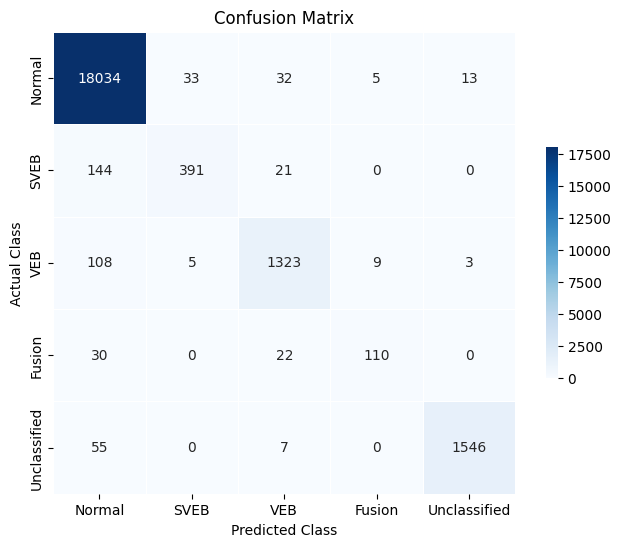

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes= np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
report = classification_report(y_true_classes, y_pred_classes)
print("Classification report: \n", report)

weighted_f1 = f1_score(y_true_classes, y_pred_classes, average="weighted")
print(f"\n Weighted F1-Score: {weighted_f1:.4f}")

cm = confusion_matrix(y_true_classes, y_pred_classes)
class_names = ['Normal', 'SVEB', 'VEB', 'Fusion', 'Unclassified']
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

### **Interpretation:**
#### As expected, the modeling results are worse with the pre-processed data, which is expressed in particular in a reduction of the Precision and recall for the minority-classes (1 and 3).However, a reduced classification performance for precision and recall can be observed for all classes. 

## **4. Interpretability (`preprocess_ekg_signals_1`):**

### **Data Prepataration and Calculation of SHAP-Values**

In [27]:
import shap

background_size = 1000 
background_indices = np.random.choice(X_train.shape[0], size=background_size, replace=False)
background_sample = X_train[background_indices]

# Select a random sample from the test dataset for explanation
test_sample_size = 1000  
X_test_sample = X_test[:test_sample_size]

explainer = shap.DeepExplainer(model, background_sample)

# Compute SHAP values for the test sample
shap_values = explainer.shap_values(X_test_sample)

# Convert the list of SHAP values to a NumPy array
shap_values_array = np.array(shap_values)  # Form: (Number of Samples, Timesteps, 1, Number of Classes)

# Remove the feature dimension
shap_values_array = shap_values_array.reshape(shap_values_array.shape[0], shap_values_array.shape[1], shap_values_array.shape[3])  # New form: (Samples, Timesteps, Classes)

# Compute the mean SHAP values over all samples
mean_shap_values = np.mean(shap_values_array, axis=0)  # Form: (Timesteps, Classes)
print("Shape of mean_shap_values:", mean_shap_values.shape)

c:\Users\maxgl\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\maxgl\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: Input. Received: the structure of inputs=['*']
  warnings.warn(


Shape of mean_shap_values: (165, 5)


### **Mean EKG-Data by Class + SHAP-Values**

In [28]:
# Visualization: 

def plot_combined_signals_and_shap(df, mean_shap_values, class_names, title):
    """
    Plots mean EKG signals and SHAP values for each class in the dataset.
    
    Parameters:
        df (DataFrame): Dataset with time-series signals and class labels in the last column.
        mean_shap_values (ndarray): Mean SHAP values for each class and time step.
        class_names (list): Names of the classes.
        title (str): Overall title for the plot.
    """
    signal_columns = df.columns[:-1]
    classes = df[df.columns[-1]].unique()
    classes.sort()
    
    num_classes = len(classes)
    timesteps = len(signal_columns)
    
    mean_signals = []
    for cls in classes:
        class_data = df[df[df.columns[-1]] == cls]
        mean_signal = class_data[signal_columns].mean(axis=0).values
        mean_signals.append(mean_signal)
    
    fig, axs = plt.subplots(num_classes * 2, 1, figsize=(15, num_classes * 4))
    cmap = plt.get_cmap('bwr')

    for i, cls in enumerate(classes):
        idx = int(cls)
        signal_plot_idx = i * 2
        shap_plot_idx = i * 2 + 1

        # Plot mean signal
        axs[signal_plot_idx].plot(range(timesteps), mean_signals[i], color='blue')
        axs[signal_plot_idx].set_title(f'Class {int(cls)} - Mean EKG-Signal')
        axs[signal_plot_idx].set_ylabel('Amplitude')
        axs[signal_plot_idx].set_xlabel('Time (Column-Index)')
        axs[signal_plot_idx].grid(True)
        axs[signal_plot_idx].set_xlim([0, timesteps])
        
        # Plot mean SHAP values
        mean_shap = mean_shap_values[:, idx]
        norm = mcolors.TwoSlopeNorm(vmin=mean_shap.min(), vcenter=0, vmax=mean_shap.max())
        axs[shap_plot_idx].bar(range(timesteps), np.ones(timesteps), 
                               color=cmap(norm(mean_shap)), edgecolor='none', width=1)
        axs[shap_plot_idx].set_title(f'Class {int(cls)} - Mean SHAP-Value')
        axs[shap_plot_idx].set_ylabel('SHAP-Value')
        axs[shap_plot_idx].set_xlabel('Time (Column-Index)')
        axs[shap_plot_idx].set_yticks([])
        axs[shap_plot_idx].set_xlim([0, timesteps])

    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()


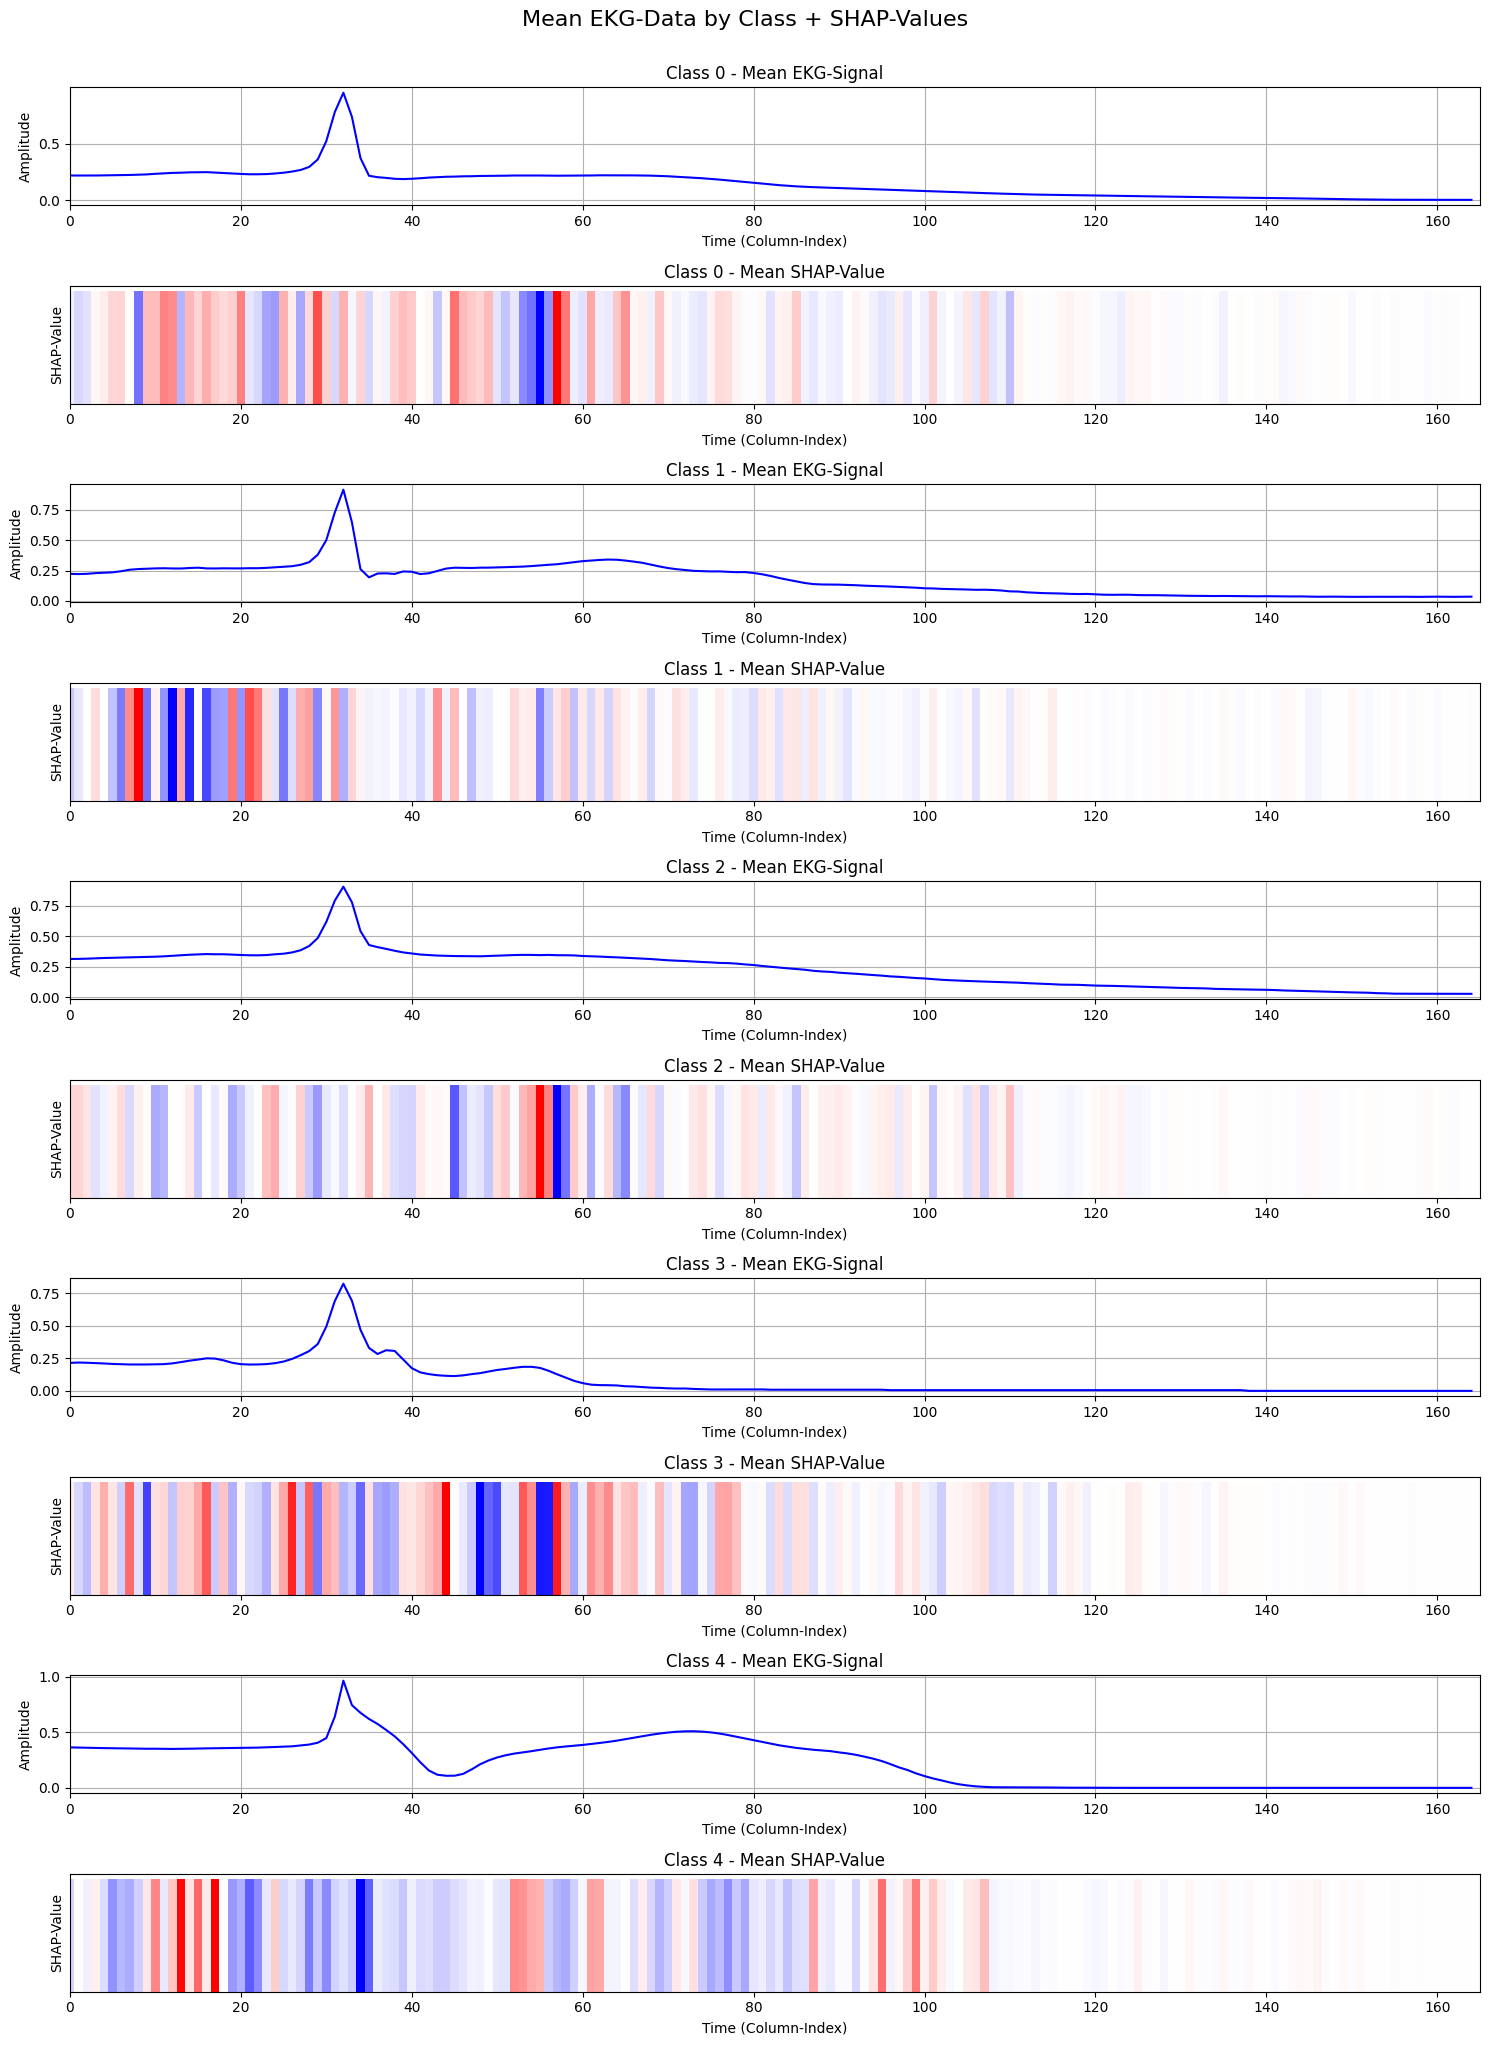

In [29]:
plot_combined_signals_and_shap(
    df=mitbih_test_df_preprocessed,
    mean_shap_values=mean_shap_values,
    class_names=class_names,
    title='Mean EKG-Data by Class + SHAP-Values'
)

### **Description of the Results:**

The visualized plot shows the **mean EKG signals** and their corresponding **SHAP values** for the five different classes. For each class, two stacked plots are presented:

1. **Mean EKG Signal (Blue Line):**
   - Displays the average amplitude of the signal across all time steps for a given class.
   - Each line represents the averaged signal from all samples in the respective class.

2. **SHAP Values (Color-Coded Bars):**
   - Highlights the importance of each time step in determining the class predictions.
   - **Red Bars:** Positive SHAP values, indicating a stronger contribution to the class prediction.
   - **Blue Bars:** Negative SHAP values, indicating less relevance or contribution against the prediction.
   - The intensity of the color represents the magnitude of the SHAP value.

#### **Interpretation:**

- **SHAP Values:**
  - The SHAP values identify key time regions that significantly influence the classification.
  - For instance:
    - For class 1, high SHAP values are shown in columns 21-23 - correlating with the P-wave which, as expected, should not occur here.
    - While the positive and negative predictive SHAP values for classes 2 and 3 are concentrated around the P and QRS wave, there is a wider spread for classes 1 and 4 in particular, so that the T wave was also relevant in the classification. 
  - The SHAP values effectively highlight the time steps that are most critical for distinguishing between classes.

#### **What is the added value of these findings?**
- The **interpretability of the model**, by showing which parts of the signal are most influential for classification decisions.
- <u>**For the first time, it is now possible to directly link the behavior of the model to the individual phases of the cardiac cycle.**</u>


#### **What could be further improved?**
- Due to long calculation times, the “background_size” and “test_sample_size” for the DeepExplainer are relatively small at 1000 in the current example. 
- Due to the considerable class imbalances in the data set, the significance of the results is limited, particularly with regard to the underrepresented classes (“SVEB” and “Fusion”).

In [30]:
def plot_top_features_per_class(mean_shap_values, class_names, top_n=10, title='Top 10 Feature Importances per Class'):
    """
    Plots the top N features with the highest SHAP values for each class.

    Parameters:
        mean_shap_values: numpy array, shape (Timesteps, Classes)
        class_names: list of class names
        top_n: number of top features to display (default=10)
        title: overall plot title
    """
    num_classes = len(class_names)
    timesteps = mean_shap_values.shape[0]
    
    # Generate feature names for timesteps
    feature_names = [f'Feature {i}' for i in range(timesteps)]
    
    # Create subplots
    fig, axs = plt.subplots(num_classes, 1, figsize=(20, 5 * num_classes))
    if num_classes == 1:  # Ensure axs is iterable for single class
        axs = [axs]
    
    for i, cls in enumerate(class_names):
        # Extract and sort SHAP values by absolute importance
        shap_values_class = mean_shap_values[:, i]
        top_indices = np.argsort(np.abs(shap_values_class))[-top_n:][::-1]
        
        # Select top features and their values
        top_features = [feature_names[j] for j in top_indices]
        top_shap_values = shap_values_class[top_indices]
        
        # Assign colors based on SHAP value sign
        colors = ['red' if val > 0 else 'blue' for val in top_shap_values]
        
        # Plot horizontal bar chart
        axs[i].barh(range(top_n), top_shap_values, color=colors)
        axs[i].set_yticks(range(top_n))
        axs[i].set_yticklabels(top_features)
        axs[i].invert_yaxis()  # Show highest importance on top
        axs[i].set_xlabel('SHAP Value')
        axs[i].set_title(f'Top {top_n} Feature Importances for Class: {cls}')
        axs[i].grid(True, axis='x', linestyle='--', alpha=0.7)
    
    # Adjust layout and add main title
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.02)
    plt.show()


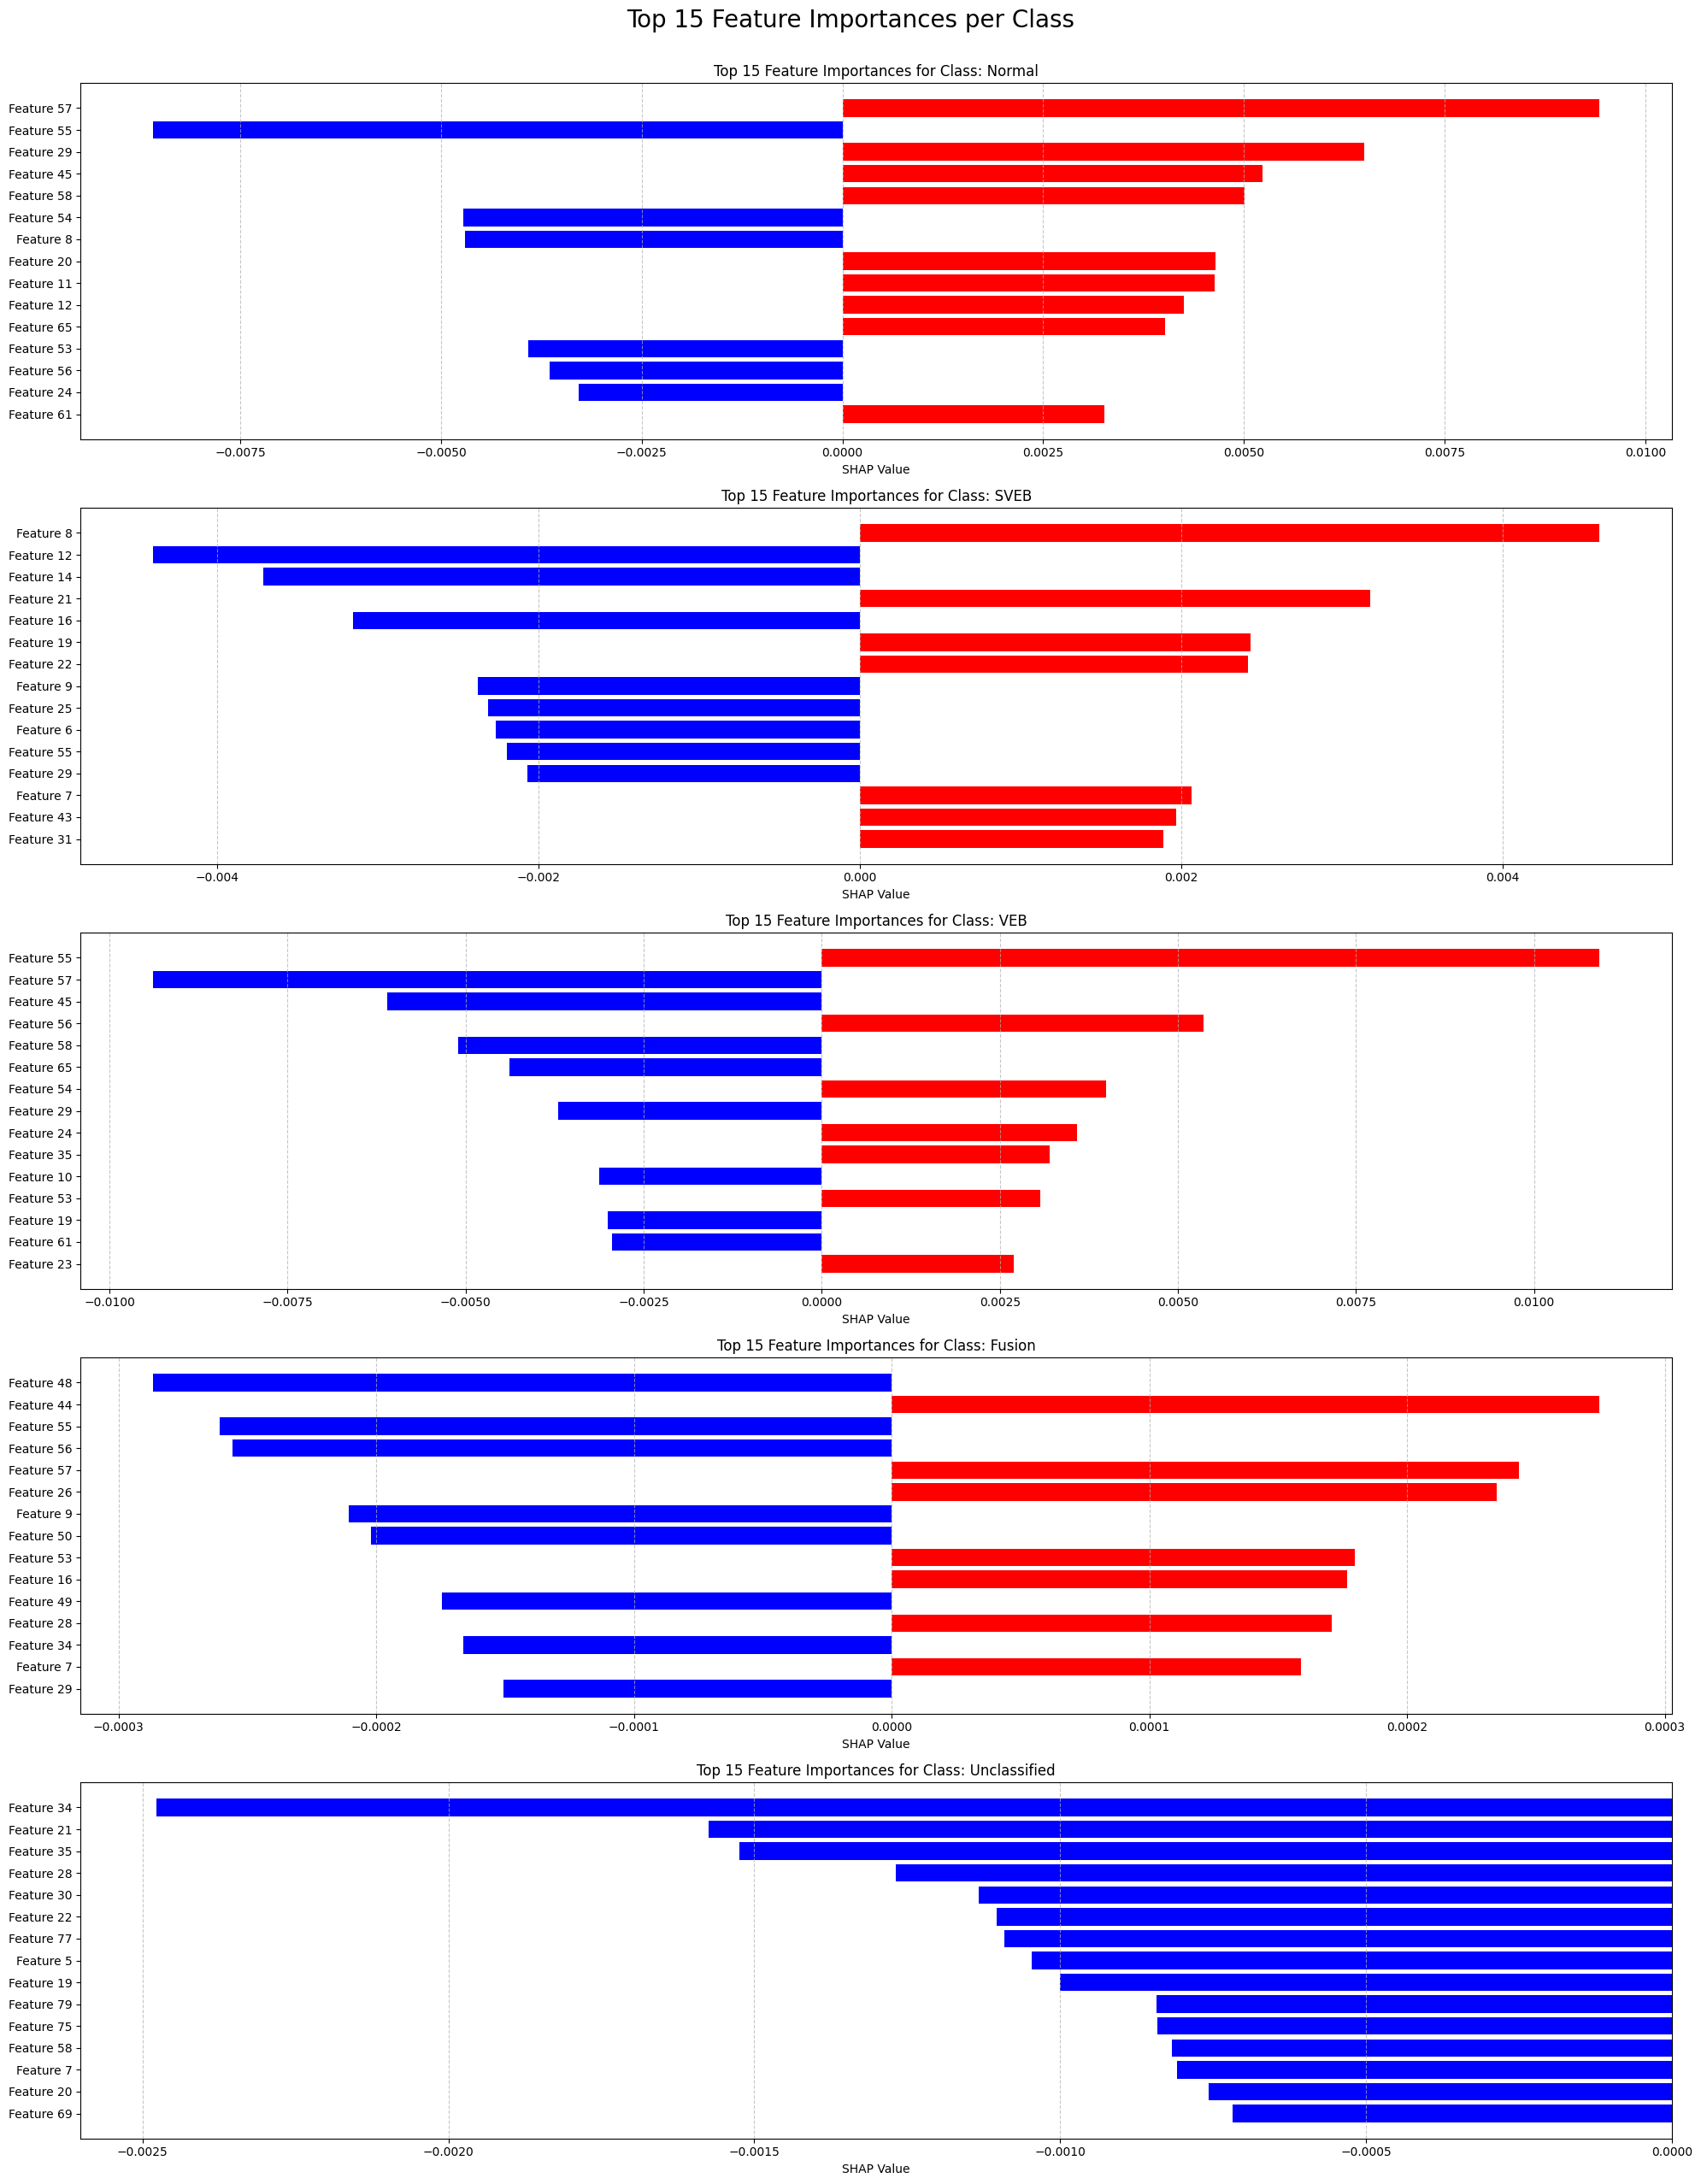

In [31]:
plot_top_features_per_class(
    mean_shap_values=mean_shap_values,
    class_names=class_names,
    top_n=15,
    title='Top 15 Feature Importances per Class'
)

## **5. Preprocessor No. 2 - Low Data Alteration ((R)-T-P-QRS):**
### **A compromise:**
#### In this paragraph, we present a second form of data pre-processing. We try to minimize some of the weaknesses of Preprocessor No. 1 - in particular the high data loss due to the deletion of 22 columns.The aim is to find a compromise between interpretability and model performance. 


In [4]:
def preprocess_ecg_signals_2(df, peak_col_index=145):
    """
    - Preprocess ECG signals to align the maximum value (R-wave) to the same column.
    - All values from the original signal remain unchanged and are only shifted.
    - In the case of a left shift, the truncated values are inserted at the point where zero-padding begins,
    but only if there are at least 10 consecutive zeros from that point onward.
    - If the first value of the truncated values differs by more than 0.05 from the last value before padding,
    the truncated values are adjusted by the difference.
    - No values are altered or duplicated.
    - Additionally, the number of left shifts, right shifts, and no shifts are counted.
    - New: No deletion of columns. When determining the R peak, the first 20 columns are ignored - but not deleted. 
    - New: Instead of a low column index, a high column index is used for centering the signal. This shifts most signals to the right, 
    resulting in less manipulation of the signal. 
    
    Parameters:
    - df: DataFrame containing ECG signals, with labels in the last column.
    - peak_col_index: Index of the column where the maximum value (R-wave) should be aligned (after column removal

    Returns: 
    - df_preprocessed (DataFrame): DataFrame with preprocessed signals.
    - shift_counts (dict): Counts of left, right, and no shifts performed.
    """
    # Signal columns excluding the label column
    signal_columns = df.columns[:-1]

    # Total number of signal columns
    num_cols = len(signal_columns)

    # Initialize counters for different shift operations
    left_shift_count = 0
    right_shift_count = 0
    no_shift_count = 0

    # Iterate over all rows (signals) in the DataFrame
    for idx in df.index:
        # Extract the signal as a numpy array
        signal = df.loc[idx, signal_columns].values

        # Step 1: Identify the R-peak (maximum value), ignoring the first 20 columns
        max_index = np.argmax(signal[20:]) + 20

        # Step 2: Calculate the shift required to align the peak
        shift = peak_col_index - max_index  # Positive: right shift, Negative: left shift

        if shift > 0:  # Case: Right shift
            right_shift_count += 1

            # Split the signal into two parts for shifting
            end_part = signal[-shift:]       # Last 'shift' elements
            main_part = signal[:-shift]      # Remaining part of the signal

            # Construct the new signal with the shifted values
            new_signal = np.concatenate((end_part, main_part))

        elif shift < 0:  # Case: Left shift
            left_shift_count += 1

            shift_abs = -shift  # Absolute value of the shift
            main_part = signal[shift_abs:]   # Signal starting after the left shift
            start_part = signal[:shift_abs]  # Part that is truncated

            # Step 3: Identify the start of zero-padding
            def find_padding_start(sig, min_zero_length=10):
                """
                Find the first position in the signal where at least `min_zero_length`
                consecutive zeros appear.
                """
                zero_runs = (sig == 0).astype(int)
                convolved = np.convolve(zero_runs, np.ones(min_zero_length, dtype=int), mode='valid')
                padding_starts = np.where(convolved == min_zero_length)[0]
                if len(padding_starts) > 0:
                    return padding_starts[0]
                else:
                    return None

            zero_index = find_padding_start(main_part, min_zero_length=10)
            if zero_index is not None:
                # Insert truncated values at the zero-padding location
                before_padding = main_part[:zero_index]
                after_padding = main_part[zero_index:]
                new_signal = np.concatenate((before_padding, start_part, after_padding))
            else:
                # If no padding is found, append truncated values at the end
                new_signal = np.concatenate((main_part, start_part))

        else:  # Case: No shift required
            no_shift_count += 1
            new_signal = signal

        # Step 4: Ensure the signal maintains its original length
        if len(new_signal) < num_cols:
            # Pad with zeros if the signal is shorter
            new_signal = np.concatenate((new_signal, np.zeros(num_cols - len(new_signal))))
        elif len(new_signal) > num_cols:
            # Truncate if the signal is longer
            new_signal = new_signal[:num_cols]

        # Update the DataFrame with the adjusted signal
        df.loc[idx, signal_columns] = new_signal

    # Create a dictionary summarizing the counts of shift operations
    shift_counts = {
        'left_shifts': left_shift_count,
        'right_shifts': right_shift_count,
        'no_shifts': no_shift_count
    }

    return df.reset_index(drop=True), shift_counts


In [5]:
# Use on Train and Test Data
mitbih_train_df_preprocessed, train_shift_counts = preprocess_ecg_signals_2(mitbih_train_df.copy(), peak_col_index=145)
mitbih_test_df_preprocessed, test_shift_counts = preprocess_ecg_signals_2(mitbih_test_df.copy(), peak_col_index=145)


### **What does `preprocess_ecg_signals_2` do?**

1. **Purpose**: Preprocess ECG signals to align the maximum value (R-wave) to a specified column while preserving all original values. 

2. **Key Features**:
   - **No column deletion**: Unlike `preprocess_ecg_signals_1`, no columns are removed. Instead, the first 20 columns are ignored when identifying the R-peak but remain part of the signal.
   - **Right-centered alignment**: Aligns the R-wave to a higher column index (`peak_col_index`), resulting in most signals being shifted to the right, thereby reducing signal manipulation.

3. **Steps**:
   - **R-peak detection**: Identifies the maximum value (R-wave) in the signal, ignoring the first 20 columns for cleaner detection.
   - **Shift calculation**:
     - Positive shifts: Right shift of the signal.
     - Negative shifts: Left shift of the signal.
   - **Signal shifting**:
     - **Right Shift**: Moves the end part of the signal to the front, aligning the R-wave with the specified column.
     - **Left Shift**:
       - Locates where padding with at least 10 consecutive zeros begins.
       - Reinserts the truncated signal values at the padding position if possible.
       - Adjusts truncated signal values if the difference between the first truncated value and the last value before padding exceeds 0.05.
   - **Signal length consistency**:
     - Ensures the processed signal retains the original length by:
       - Padding with zeros if the signal is shorter.
       - Truncating the signal if it becomes longer.

4. **Tracking shifts**:
   - Counts the number of left shifts, right shifts, and no shifts performed for reporting.

5. **Output**:
   - **Preprocessed DataFrame**: Contains the shifted ECG signals.
   - **Shift counts**: A dictionary with counts of left, right, and no shifts performed.

### **Comparison of original and preprocessed Signal:**

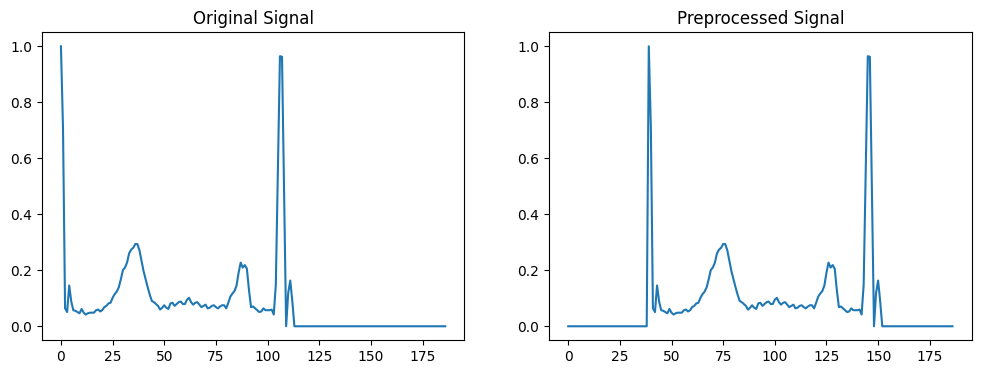

In [6]:
idx_example = 1  # Exemplary Index

original_signal = mitbih_train_df.drop(mitbih_train_df.columns[0:0], axis=1).iloc[idx_example, :-1].values
processed_signal = mitbih_train_df_preprocessed.iloc[idx_example, :-1].values

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(original_signal)
plt.title('Original Signal')

plt.subplot(1, 2, 2)
plt.plot(processed_signal)
plt.title('Preprocessed Signal')
plt.show()

In [7]:
print(train_shift_counts)
print(test_shift_counts)

{'left_shifts': 2020, 'right_shifts': 85355, 'no_shifts': 178}
{'left_shifts': 503, 'right_shifts': 21342, 'no_shifts': 46}


### **Results of Averaged EKG-Signal by Class after `preprocess_ecg_signals_2`:**

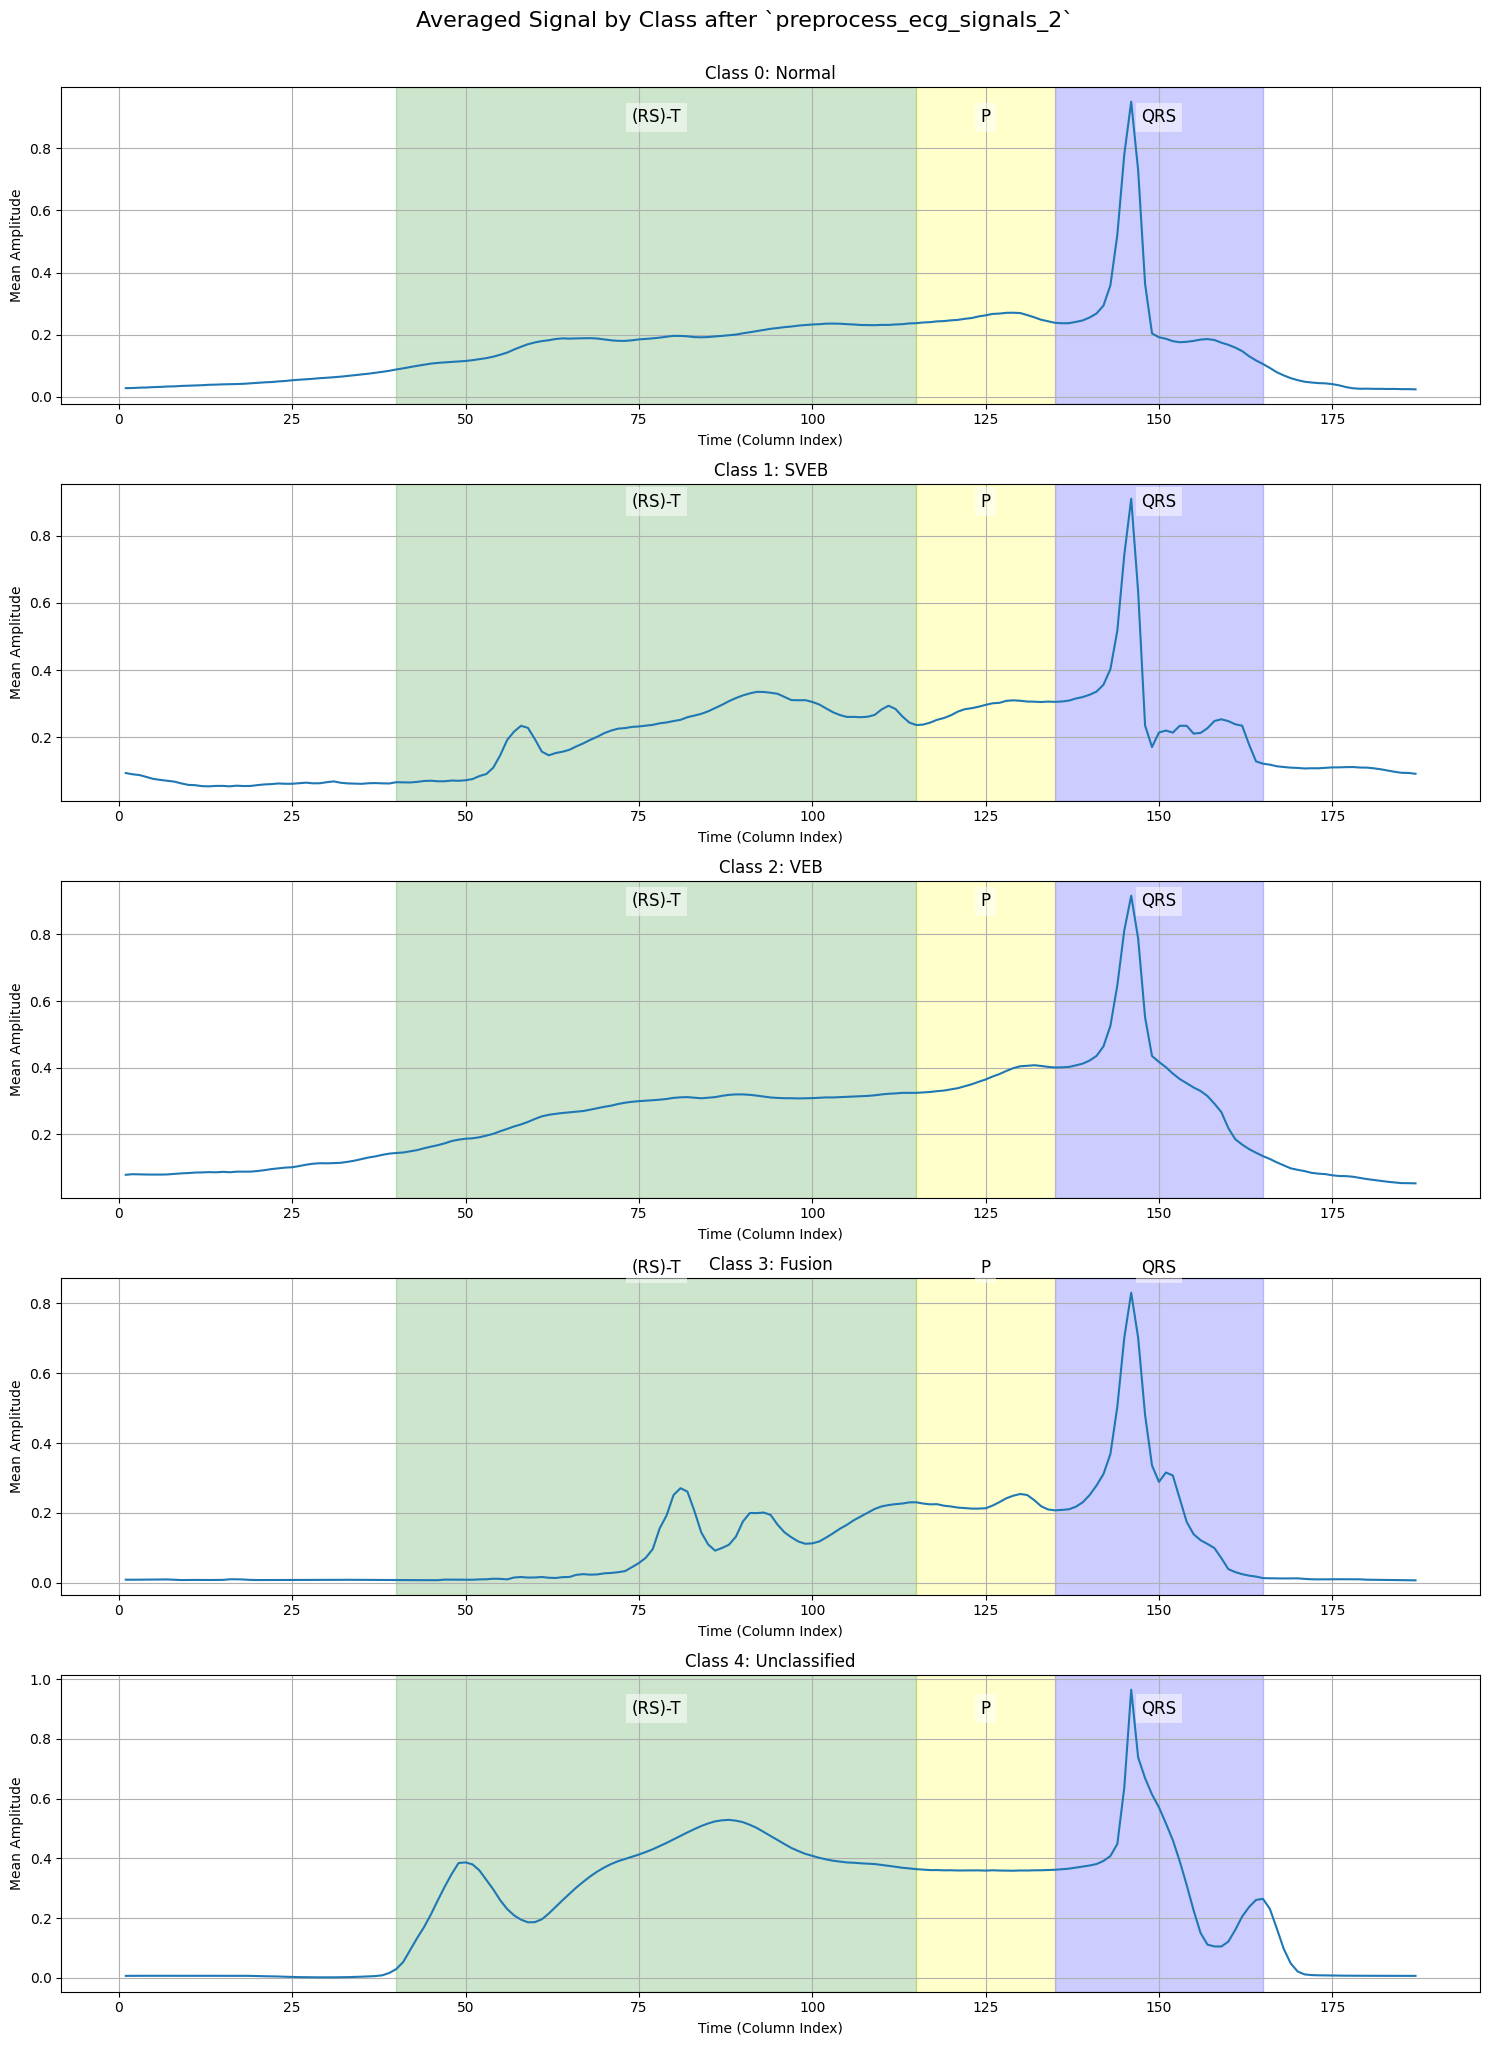

In [8]:

# Visualization of Mean-EKG Data (After Advanced Preprocessing)

class_names = ['Normal', 'SVEB', 'VEB', 'Fusion', 'Unclassified']

# Function to calculate and visualize the average signals for each class
def plot_average_signals_with_background(df, title, class_names):
    signal_columns = df.columns[:-1]  # All columns except the last one (signal data)
    classes = df[df.columns[-1]].unique()  # Extract unique class labels from the last column
    classes.sort()  # Sort classes for consistent visualization

    # Define color-coded regions and their labels
    regions = [
        {"range": (115, 135), "color": "yellow", "label": "P"},
        {"range": (135, 165), "color": "blue", "label": "QRS"},
        {"range": (40,115), "color": "green", "label": "(RS)-T"}
    ]

    # Create subplots for each class
    fig, axs = plt.subplots(len(classes), 1, figsize=(15, 20))

    for i, cls in enumerate(classes):
        # Filter data for the current class
        class_data = df[df[df.columns[-1]] == cls]
        # Calculate the mean signal for the current class
        mean_signal = class_data[signal_columns].mean(axis=0)

        # Plot the mean signal
        axs[i].plot(signal_columns, mean_signal, label='Mean Signal')
        axs[i].set_title(f'Class {int(cls)}: {class_names[int(cls)]}')
        axs[i].set_ylabel('Mean Amplitude')
        axs[i].set_xlabel('Time (Column Index)')
        axs[i].grid(True)

        # Add colored regions with text
        for region in regions:
            start, end = region["range"]
            color = region["color"]
            label = region["label"]
            axs[i].axvspan(start, end, color=color, alpha=0.2)
            text_x = (start + end) / 2
            axs[i].text(
                text_x, 0.9, label, fontsize=12, color="black",
                ha="center", va="center", bbox=dict(facecolor="white", alpha=0.5, edgecolor="none")
            )

    # Adjust layout and add a main title
    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()

# Visualization for training data with class labels
plot_average_signals_with_background(mitbih_train_df_preprocessed, 'Averaged Signal by Class after `preprocess_ecg_signals_2`', class_names)

### **Advantages and Disadvantages of `preprocess_ekg_signals_2`:**
- Advantages: 
   - No loss of information - the signals are simply moved but no columns are deleted. 
   - Possibility of assigning the averaged signals to the individual phases of the cardiac cycle is generally retained
   Less manipulation of signals by shifting to the right (column index 145)

- Disadvantages: 
   - The first (incomplete) R-peak of the signal blurs with the range of the T-wave - this reduces the interpretability in this range

### **Modeling with `preprocess_ekg_signal_2`:**

In [9]:
# Train Test Split (Preprocessed Data)
X_train = mitbih_train_df_preprocessed.iloc[:, :-1]
y_train = mitbih_train_df_preprocessed.iloc[:, -1]
X_test = mitbih_test_df_preprocessed.iloc[:, :-1]
y_test = mitbih_test_df_preprocessed.iloc[:, -1]


y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

X_train = np.expand_dims(X_train.values, axis=-1)
X_test = np.expand_dims(X_test.values, axis=-1)

print("Shape of X_train, y_train: ", X_train.shape, y_train.shape)
print("Shape of X_test, y_test: ", X_test.shape, y_test.shape)

Shape of X_train, y_train:  (87553, 187, 1) (87553, 5)
Shape of X_test, y_test:  (21891, 187, 1) (21891, 5)


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Residual Block Definition
def residual_block(x, filters, kernel_size=3):
    # Shortcut connection
    shortcut = x

    # Adjust shortcut dimensions if necessary
    if x.shape[-1] != filters:
        shortcut = Conv1D(filters=filters, kernel_size=1, padding='same')(shortcut)
    
    # First Conv1D layer
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Conv1D layer
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Add the shortcut to the output
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Model input
inputs = Input(shape=(187, 1), name="Input")  # Shape adjusted according to preprocessing

# 1D-CNN layer with the best hyperparameters
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

# Residual block 1
x = residual_block(x, filters=64)

# Residual block 2
x = residual_block(x, filters=128)

# Residual block 3
x = residual_block(x, filters=256)

# Flatten layer
x = Flatten()(x)

# Dense layers with the best dropout values
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)  # Best dropout for layer 1

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)  # Best dropout for layer 2

# Output layer for multi-class classification
output_layer = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=output_layer)

# Compile the model with the best learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
training_history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print(f"Test loss: {evaluation[0]}, Test accuracy: {evaluation[1]}")

Epoch 1/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.9038 - loss: 0.3566 - val_accuracy: 0.9596 - val_loss: 0.1447
Epoch 2/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 78s 36ms/step - accuracy: 0.9581 - loss: 0.1629 - val_accuracy: 0.9736 - val_loss: 0.0976
Epoch 3/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 78s 36ms/step - accuracy: 0.9686 - loss: 0.1155 - val_accuracy: 0.9762 - val_loss: 0.0835
Epoch 4/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - accuracy: 0.9759 - loss: 0.0901 - val_accuracy: 0.9760 - val_loss: 0.0850
Epoch 5/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 78s 36ms/step - accuracy: 0.9789 - loss: 0.0762 - val_accuracy: 0.9793 - val_loss: 0.0772
Epoch 6/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - accuracy: 0.9814 - loss: 0.0654 - val_accuracy: 0.9822 - val_loss: 0.0662
Epoch 7/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - accuracy: 0.9829 - loss: 0.0565 - val_accuracy: 0.9799 - val_loss: 0.0747
Epoch 8/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - accuracy: 0.9843 -

### **Results of Modeling with `preprocess_ekg_signals_2`:**

685/685 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     18117
           1       0.92      0.76      0.83       556
           2       0.96      0.95      0.95      1448
           3       0.89      0.76      0.82       162
           4       1.00      0.98      0.99      1608

    accuracy                           0.98     21891
   macro avg       0.95      0.89      0.92     21891
weighted avg       0.98      0.98      0.98     21891


 Weighted F1-Score: 0.9834


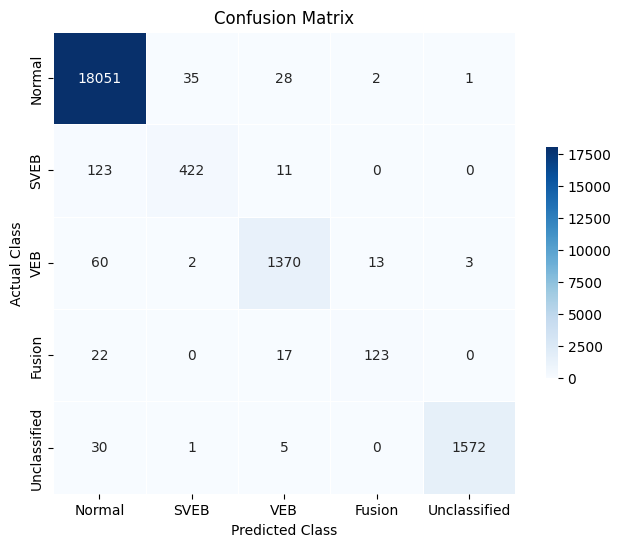

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
y_pred_classes= np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
report = classification_report(y_true_classes, y_pred_classes)
print("Classification report: \n", report)

weighted_f1 = f1_score(y_true_classes, y_pred_classes, average="weighted")
print(f"\n Weighted F1-Score: {weighted_f1:.4f}")

cm = confusion_matrix(y_true_classes, y_pred_classes)
class_names = ['Normal', 'SVEB', 'VEB', 'Fusion', 'Unclassified']
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

### **Interpretation**
#### The results have now improved. Qualitatively, the classification results of `preprocess_ekg_signals_2` lie between those of the original results and those of `preprocess_ekg_signals_1`. This corresponds to the reduced loss of information with this approach.

## **6. Interpretability (`preprocess_ekg_signals_2`):**

### **Data Prepataration and Calculation of SHAP-Values**

In [14]:
background_size = 1000 
background_indices = np.random.choice(X_train.shape[0], size=background_size, replace=False)
background_sample = X_train[background_indices]

# Select a random sample from the test dataset for explanation
test_sample_size = 1000  
X_test_sample = X_test[:test_sample_size]

# Create a SHAP explainer using the gradient-based explainer
explainer = shap.DeepExplainer(model, background_sample)

# Compute SHAP values for the test sample
shap_values = explainer.shap_values(X_test_sample)

# Convert the list of SHAP values to a NumPy array
shap_values_array = np.array(shap_values)  # Form: (Number of Samples, Timesteps, 1, Number of Classes)

# Remove the feature dimension
shap_values_array = shap_values_array.reshape(shap_values_array.shape[0], shap_values_array.shape[1], shap_values_array.shape[3])  # New form: (Samples, Timesteps, Classes)

# Compute the mean SHAP values over all samples
mean_shap_values = np.mean(shap_values_array, axis=0)  # Form: (Timesteps, Classes)
print("Shape of mean_shap_values:", mean_shap_values.shape)

c:\Users\maxgl\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\maxgl\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: Input. Received: the structure of inputs=['*']
  warnings.warn(


Shape of mean_shap_values: (187, 5)


### **Mean EKG-Data by Class + SHAP-Values**

In [15]:
# Visualization: 

def plot_combined_signals_and_shap(df, mean_shap_values, class_names, title):
    """
    Plots mean EKG signals and SHAP values for each class in the dataset.
    
    Parameters:
        df (DataFrame): Dataset with time-series signals and class labels in the last column.
        mean_shap_values (ndarray): Mean SHAP values for each class and time step.
        class_names (list): Names of the classes.
        title (str): Overall title for the plot.
    """
    signal_columns = df.columns[:-1]
    classes = df[df.columns[-1]].unique()
    classes.sort()
    
    num_classes = len(classes)
    timesteps = len(signal_columns)
    
    mean_signals = []
    for cls in classes:
        class_data = df[df[df.columns[-1]] == cls]
        mean_signal = class_data[signal_columns].mean(axis=0).values
        mean_signals.append(mean_signal)
    
    fig, axs = plt.subplots(num_classes * 2, 1, figsize=(15, num_classes * 4))
    cmap = plt.get_cmap('bwr')

    for i, cls in enumerate(classes):
        idx = int(cls)
        signal_plot_idx = i * 2
        shap_plot_idx = i * 2 + 1

        # Plot mean signal
        axs[signal_plot_idx].plot(range(timesteps), mean_signals[i], color='blue')
        axs[signal_plot_idx].set_title(f'Class {int(cls)} - Mean EKG-Signal')
        axs[signal_plot_idx].set_ylabel('Amplitude')
        axs[signal_plot_idx].set_xlabel('Time (Column-Index)')
        axs[signal_plot_idx].grid(True)
        axs[signal_plot_idx].set_xlim([0, timesteps])
        
        # Plot mean SHAP values
        mean_shap = mean_shap_values[:, idx]
        norm = mcolors.TwoSlopeNorm(vmin=mean_shap.min(), vcenter=0, vmax=mean_shap.max())
        axs[shap_plot_idx].bar(range(timesteps), np.ones(timesteps), 
                               color=cmap(norm(mean_shap)), edgecolor='none', width=1)
        axs[shap_plot_idx].set_title(f'Class {int(cls)} - Mean SHAP-Value')
        axs[shap_plot_idx].set_ylabel('SHAP-Value')
        axs[shap_plot_idx].set_xlabel('Time (Column-Index)')
        axs[shap_plot_idx].set_yticks([])
        axs[shap_plot_idx].set_xlim([0, timesteps])

    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()


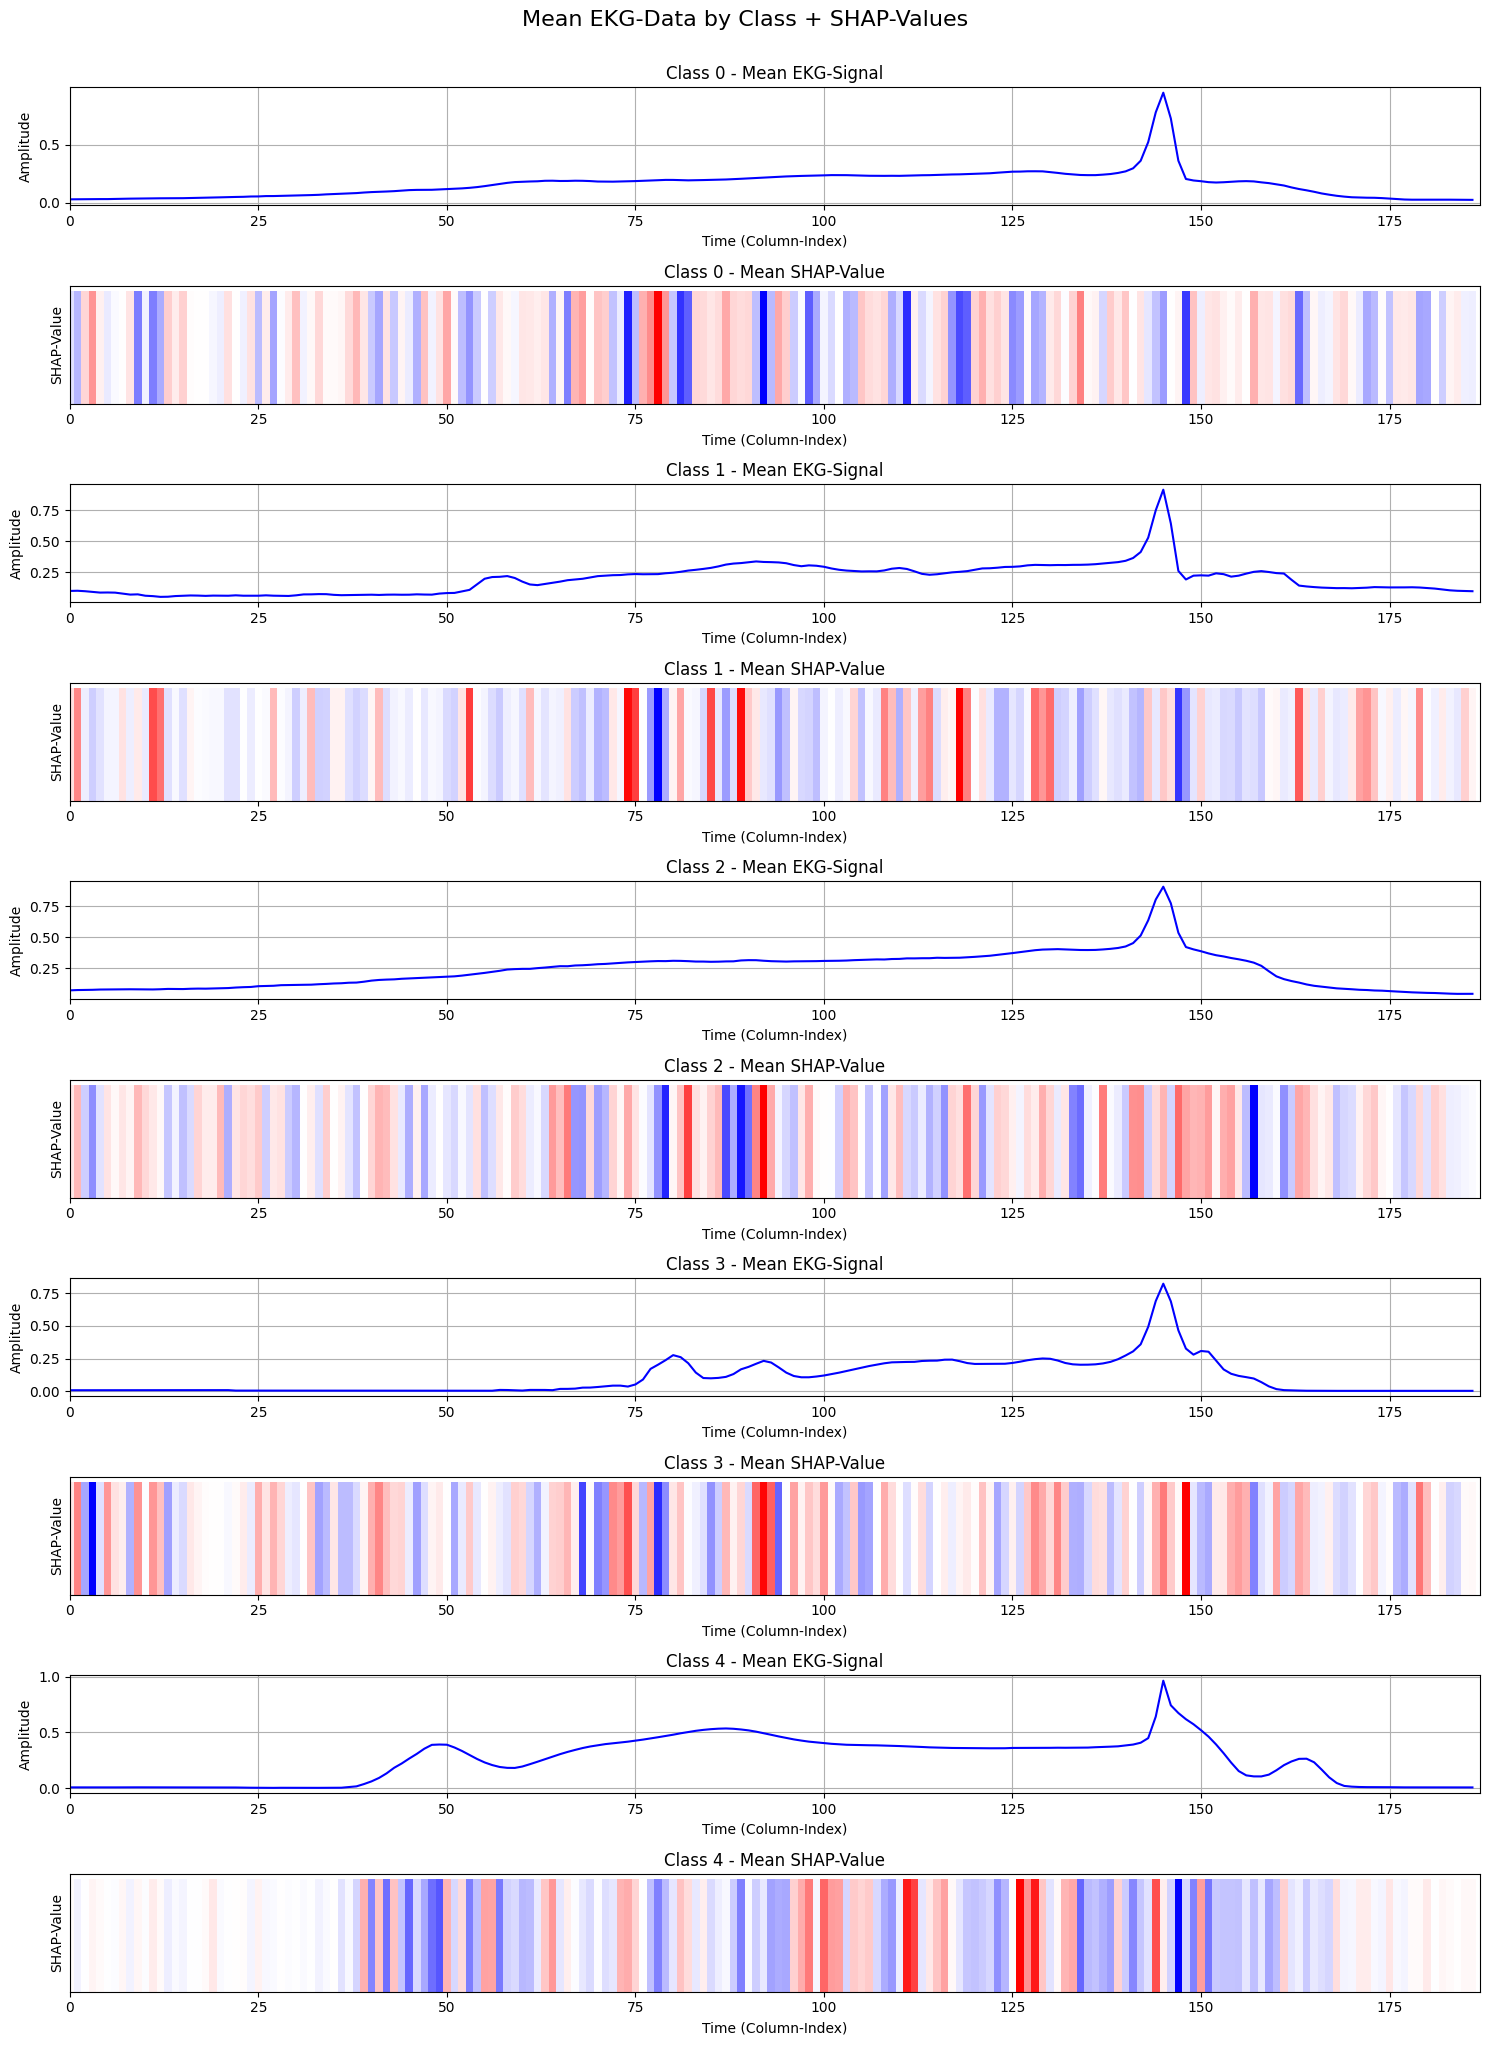

In [16]:
plot_combined_signals_and_shap(
    df=mitbih_test_df_preprocessed,
    mean_shap_values=mean_shap_values,
    class_names=class_names,
    title='Mean EKG-Data by Class + SHAP-Values'
)

### **Description of the Results:**

The visualized plot shows the **mean EKG signals** and their corresponding **SHAP values** for the five different classes. For each class, two stacked plots are presented:

1. **Mean EKG Signal (Blue Line):**
   - Displays the average amplitude of the signal across all time steps for a given class.
   - Each line represents the averaged signal from all samples in the respective class.

2. **SHAP Values (Color-Coded Bars):**
   - Highlights the importance of each time step in determining the class predictions.
   - **Red Bars:** Positive SHAP values, indicating a stronger contribution to the class prediction.
   - **Blue Bars:** Negative SHAP values, indicating less relevance or contribution against the prediction.
   - The intensity of the color represents the magnitude of the SHAP value.

#### **Interpretation:**

- **SHAP Values:**
  - The SHAP values identify key time regions that significantly influence the classification.
  - For instance:
    - While clear patterns can be identified in the distribution of SHAP values between the classes, compared to `preprocess_ekg_signals_1` a more homogeneous distribution can be seen in which many columns were relevant for the different classes for the differentiation according to SHAP values. 
    - With regard to the relatively frequency-rigid class 4 (large proportion of pacemaker stimulation), the previous (incomplete) RS peak can be identified and, based on the SHAP values, it is possible to attribute a relevant significance for the classification to this class. 
  - The SHAP values effectively highlight the time steps that are most critical for distinguishing between classes.

#### **What is the added value of these findings?**
- <u>**It is possible to directly link the behavior of the model to the individual phases of the cardiac cycle.**</u>
- Compared to `preprocess_ekg_signals_1`, the basic structure of the preprocessing is different this time. No data was deleted and a clear distinction between the initial RS peak and T wave is no longer possible in the averaged signal. 


#### **What could be further improved?**
- Due to long calculation times, the “background_size” and “test_sample_size” for the DeepExplainer are relatively small at 1000 in the current example. 
- Due to the considerable class imbalances in the data set, the significance of the results is limited, particularly with regard to the underrepresented classes (“SVEB” and “Fusion”).

In [17]:
def plot_top_features_per_class(mean_shap_values, class_names, top_n=10, title='Top 10 Feature Importances per Class'):
    """
    Plots the top N features with the highest SHAP values for each class.

    Parameters:
        mean_shap_values: numpy array, shape (Timesteps, Classes)
        class_names: list of class names
        top_n: number of top features to display (default=10)
        title: overall plot title
    """
    num_classes = len(class_names)
    timesteps = mean_shap_values.shape[0]
    
    # Generate feature names for timesteps
    feature_names = [f'Feature {i}' for i in range(timesteps)]
    
    # Create subplots
    fig, axs = plt.subplots(num_classes, 1, figsize=(20, 5 * num_classes))
    if num_classes == 1:  # Ensure axs is iterable for single class
        axs = [axs]
    
    for i, cls in enumerate(class_names):
        # Extract and sort SHAP values by absolute importance
        shap_values_class = mean_shap_values[:, i]
        top_indices = np.argsort(np.abs(shap_values_class))[-top_n:][::-1]
        
        # Select top features and their values
        top_features = [feature_names[j] for j in top_indices]
        top_shap_values = shap_values_class[top_indices]
        
        # Assign colors based on SHAP value sign
        colors = ['red' if val > 0 else 'blue' for val in top_shap_values]
        
        # Plot horizontal bar chart
        axs[i].barh(range(top_n), top_shap_values, color=colors)
        axs[i].set_yticks(range(top_n))
        axs[i].set_yticklabels(top_features)
        axs[i].invert_yaxis()  # Show highest importance on top
        axs[i].set_xlabel('SHAP Value')
        axs[i].set_title(f'Top {top_n} Feature Importances for Class: {cls}')
        axs[i].grid(True, axis='x', linestyle='--', alpha=0.7)
    
    # Adjust layout and add main title
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.02)
    plt.show()


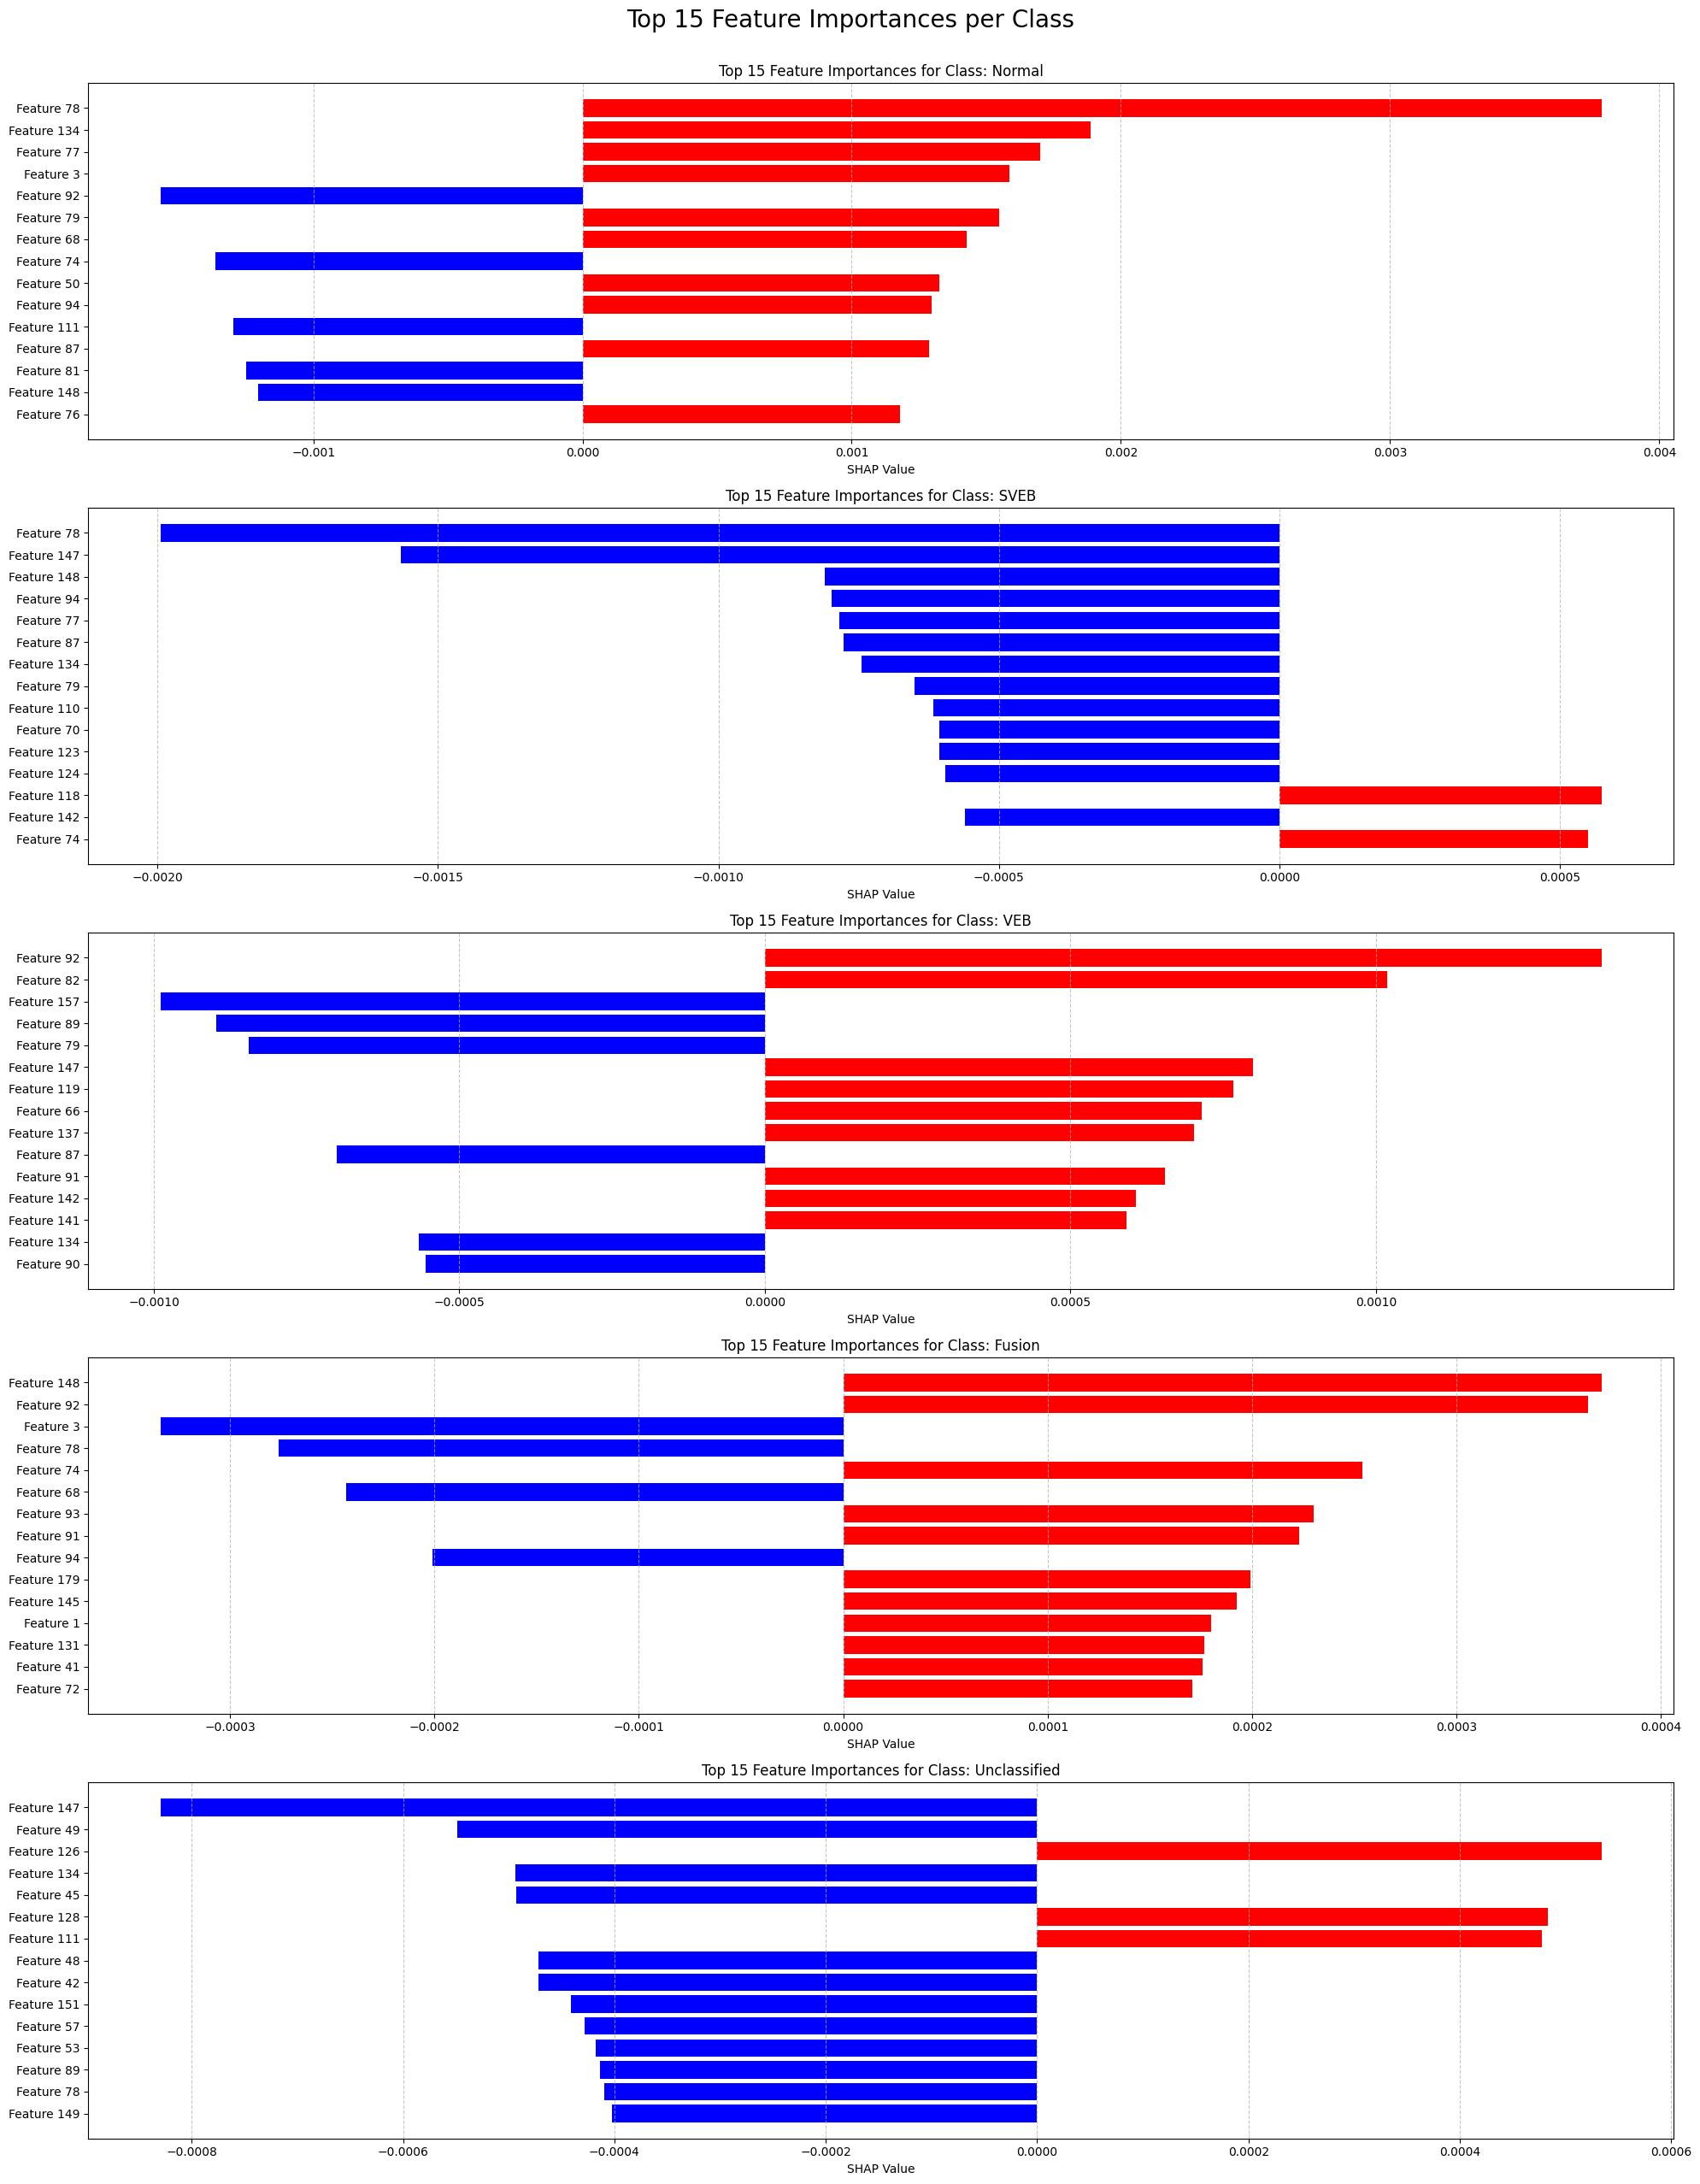

In [18]:
plot_top_features_per_class(
    mean_shap_values=mean_shap_values,
    class_names=class_names,
    top_n=15,
    title='Top 15 Feature Importances per Class'
)

## **7. Summary:**

#### In this notebook we have tried to present an approach that makes interpretability of the deep learning model accessible without compromising the classification performance of the model too much. 
#### As a deep learning model, we have presented an alternative approach with 1-D CNN and residual connections which shows good performance when applied to the unchanged data. 
#### Two different ways of data preprocessing were presented and the results were evaluated with regard to the classification performance of the model. 
#### Finally, a feature importance analysis was carried out for each form of data preprocessing using SHAP (DeepExplainer) and the results were discussed. 
#### We believe that with `preprocess_ekg_signals_2` we have found an acceptable compromise between interpretability and performance. 
#### A further optimization would be the calculation of SHAP values on larger samples with higher available computing power.